In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.QeCalculator(rr)
#code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler direct


In [5]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [ ]:
# RunRules for m100
nodes = 32 # 16
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_PhoGra',qos='m100_qos_bprod',
                memory='230GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.YamboCalculator(rr) #,reformat=False
code.global_options()

# BSE analysis for monolayer MoS$_2$

We compute the absorption spectrum of the monolayer MoS$_2$ within the BSE framework.

We make usage of the convergence analysis and of the ndb databases created in the GW runlevel

First we build and init the run directories and perform link off the ndb database computed
in the GW analysis

In [6]:
kpoints = [18,30,42]

for k in kpoints:
    source_dir = 'DFT_analysis/kpoints_%s-nbnds_250.save'%k
    run_dir = 'BSE_analysis/kpoints_%s-nbnds_250'%k
    Tools.init_yambo_run_dir(Tools.make_p2y(source_dir),run_dir=run_dir)

SAVE folder DFT_analysis/kpoints_18-nbnds_250.save/SAVE already present. No operations performed.
SAVE folder already present in BSE_analysis/kpoints_18-nbnds_250. No operations performed.
SAVE folder DFT_analysis/kpoints_30-nbnds_250.save/SAVE already present. No operations performed.
SAVE folder already present in BSE_analysis/kpoints_30-nbnds_250. No operations performed.
SAVE folder DFT_analysis/kpoints_42-nbnds_250.save/SAVE already present. No operations performed.
SAVE folder already present in BSE_analysis/kpoints_42-nbnds_250. No operations performed.


We create a link of the folders with the ndb database created in the _GW_analysis_ in the _BSE_analysis_ folder

In [7]:
def find_ndbs(path):
    ndbs =  []
    files = os.listdir(path)
    for f in files:
        if 'ndb_' in f : ndbs.append(os.path.abspath(os.path.join(path,f)))
    return ndbs

def make_link(ndbs,dest):
    abs_dest = os.path.abspath(dest)
    for ndb in ndbs:
        ndb_name = ndb.split('/')[-1]
        target = os.path.join(abs_dest,ndb_name)
        if not os.path.isdir(target):
            print(ndb,target)
            os.symlink(ndb,target,target_is_directory=True)

In [8]:
for k in kpoints:
    ndbs = find_ndbs('GW_analysis/kpoints_%s-nbnds_250/'%k)
    make_link(ndbs,'BSE_analysis/kpoints_%s-nbnds_250/'%k)

/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/GW_analysis/kpoints_18-nbnds_250/ndb_em1d-ngsblkxp_6.0-bndsrnxp_250 /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/BSE_analysis/kpoints_18-nbnds_250/ndb_em1d-ngsblkxp_6.0-bndsrnxp_250


## BSE convergence analysis for the low energy excitations

We test the optimal BSE parameters by constructing the absorption spectrum in the low
energy range. In this way we analyze the effects of the relevant parameters of a BSE calculation
and we study the convergence w.r.t to the $k$-points sampling.

The analysis is performed on-top of the DFT computations using a scissor to reproduce the 
experimental gap

In [5]:
dft_gap = 1.78
exp_gap = 2.4 # value to be checked
scissor = exp_gap-dft_gap # eV
print('scissor',scissor)
kpoints = [18,30,42]

scissor 0.6199999999999999


First we test the convergence of the spectrum w.r.t to number of bands used in the BSE calculations.

We perform this analysis in the 18x18x1 grid without the rim_w

In [39]:
k = kpoints[0]
run_dir = 'BSE_analysis/kpoints_%s-nbnds_250/'%k

RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
NGsBlkXs = 6.0 # Ha G size of the response function
EXXRLvcs = 30. # Ha use this value for the BSENGexx variable
BndsRnXs = [1,250] # Polarization function bands
FFTGvecs = 40. # Ha 
elec_field = [1.,0.,0.]
BSEBands = [[25,28],[25,30],[23,30]]
energy_range = [0,4] # eV
energy_step = 1000
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -r -o b -k sex -y d',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=NGsBlkXs,FFTGvecs=FFTGvecs)
inp.set_array_variables(BndsRnXs=BndsRnXs,BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
inp.set_array_variables(BEnSteps=energy_step)
inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')     

for bsebands in BSEBands:
    inp.set_array_variables(BSEBands=bsebands)
    idd = 'bse-bsebands_%s-%s_norimw'%(bsebands[0],bsebands[1])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                 jobname=[idd,',ndb_em1d-ngsblkxp_6.0-bndsrnxp_250','ndb_rim_cutoff','ndb_dipoles-bnds_250'],reformat=True)

Initialize a Dataset with 1 parallel tasks


In [57]:
#study.runs[1]

In [41]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of bse-bsebands_25-28_norimw
Task [0] ended 
 
Run the task [1] 
run command: mpirun -np 32 yambo -F bse-bsebands_25-30_norimw.in -J "bse-bsebands_25-30_norimw,,ndb_em1d-ngsblkxp_6.0-bndsrnxp_250,ndb_rim_cutoff,ndb_dipoles-bnds_250" -C bse-bsebands_25-30_norimw
slurm submit:  cd BSE_analysis/kpoints_18-nbnds_250/ ; sbatch job_bse-bsebands_25-30_norimw.sh
computation bse-bsebands_25-30_norimw is running...
computation bse-bsebands_25-30_norimw ended
Run performed in 06m-06s
Task [1] ended 
 
Run the task [2] 
Skip the run of bse-bsebands_23-30_norimw
Task [2] ended 
 


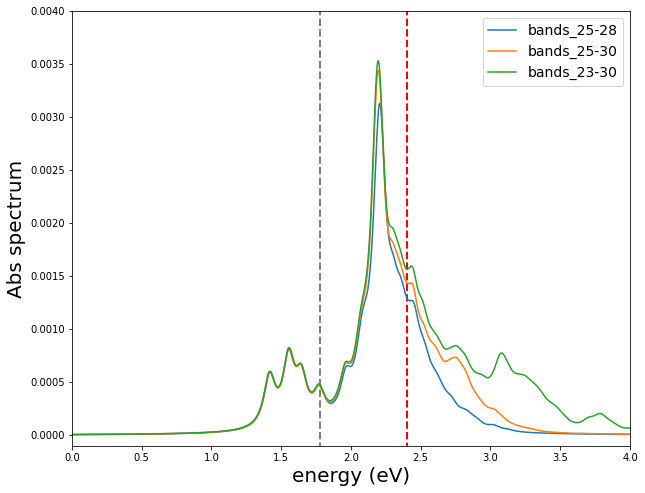

In [42]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,b in enumerate(BSEBands):
    data = results[ind].data['eps_q1_diago_bse']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax.plot(energy,eps_im,label='bands_%s-%s'%(b[0],b[1])) 
ax.vlines(dft_gap,-1,10,linestyles='--',color='gray',linewidth=2)
ax.vlines(exp_gap,-1,10,linestyles='--',color='red',linewidth=2)
ax.set_xlim(0,4)
ax.set_ylim(-1e-4,4e-3)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

Next we test the convergence w.r.t to $k$-points samplings

In [52]:
RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
NGsBlkXs = 6.0 # Ha G size of the response function
EXXRLvcs = 30. # Ha use this value for the BSENGexx variable
BndsRnXs = [1,250] # Polarization function bands
FFTGvecs = 40. # Ha 
elec_field = [1.,0.,0.]
BSEBands = [25,30]
energy_range = [0,4] # eV
energy_step = 1000
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=2,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    run_dir = 'BSE_analysis/kpoints_%s-nbnds_250/'%k
    inp = I.YamboInput('yambo -r -o b -k sex -y d',folder=run_dir)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=NGsBlkXs,FFTGvecs=FFTGvecs)
    inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
    inp.set_array_variables(BSEBands=BSEBands)
    inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
    inp.set_array_variables(BEnSteps=energy_step)
    inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')     
    idd = 'bse-bsebands_%s-%s-kpoints_%s_norimw'%(BSEBands[0],BSEBands[1],k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                 jobname=[idd,',ndb_em1d-ngsblkxp_6.0-bndsrnxp_250','ndb_rim_cutoff','ndb_dipoles-bnds_250'],reformat=True)

Initialize a Dataset with 2 parallel tasks


In [56]:
#study.runs[2]

In [54]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1], [2]] 

Run the task [0, 1] 
Skip the run of bse-bsebands_25-30-kpoints_18_norimw
Skip the run of bse-bsebands_25-30-kpoints_30_norimw
Task [0, 1] ended 
 
Run the task [2] 
Skip the run of bse-bsebands_25-30-kpoints_42_norimw
Task [2] ended 
 


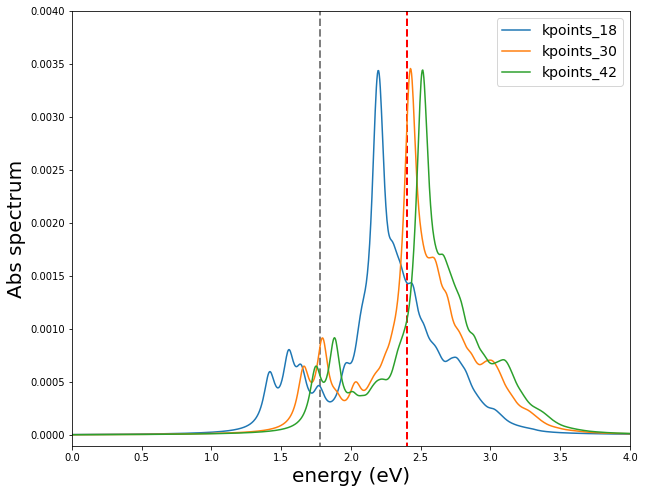

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,k in enumerate(kpoints):
    data = results[ind].data['eps_q1_diago_bse']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax.plot(energy,eps_im,label='kpoints_%s'%k) 
ax.vlines(dft_gap,-1,10,linestyles='--',color='gray',linewidth=2)
ax.vlines(exp_gap,-1,10,linestyles='--',color='red',linewidth=2)
ax.set_xlim(0,4)
ax.set_ylim(-1e-4,4e-3)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

We repeat the $k$-points convergence using the rim_w option

In [62]:
RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
NGsBlkXs = 6.0 # Ha G size of the response function
EXXRLvcs = 30. # Ha use this value for the BSENGexx variable
BndsRnXs = [1,250] # Polarization function bands
FFTGvecs = 40. # Ha 
elec_field = [1.,0.,0.]
BSEBands = [25,30]
energy_range = [0,4] # eV
energy_step = 1000
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=2,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    run_dir = 'BSE_analysis/kpoints_%s-nbnds_250/'%k
    inp = I.YamboInput('yambo -r -o b -k sex -y d',folder=run_dir)
    inp.activate_RIM_W()   
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=NGsBlkXs,FFTGvecs=FFTGvecs)
    inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
    inp.set_array_variables(BSEBands=BSEBands)
    inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
    inp.set_array_variables(BEnSteps=energy_step)
    inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')     
    idd = 'bse-bsebands_%s-%s-kpoints_%s_rimw'%(BSEBands[0],BSEBands[1],k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                 jobname=[idd,',ndb_em1d-ngsblkxp_6.0-bndsrnxp_250','ndb_rim_cutoff','ndb_dipoles-bnds_250'],reformat=False)

Initialize a Dataset with 2 parallel tasks


In [69]:
#study.runs[0]

In [65]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1], [2]] 

Run the task [0, 1] 
Skip the run of bse-bsebands_25-30-kpoints_18_rimw
Skip the run of bse-bsebands_25-30-kpoints_30_rimw
Task [0, 1] ended 
 
Run the task [2] 
Skip the run of bse-bsebands_25-30-kpoints_42_rimw
Task [2] ended 
 


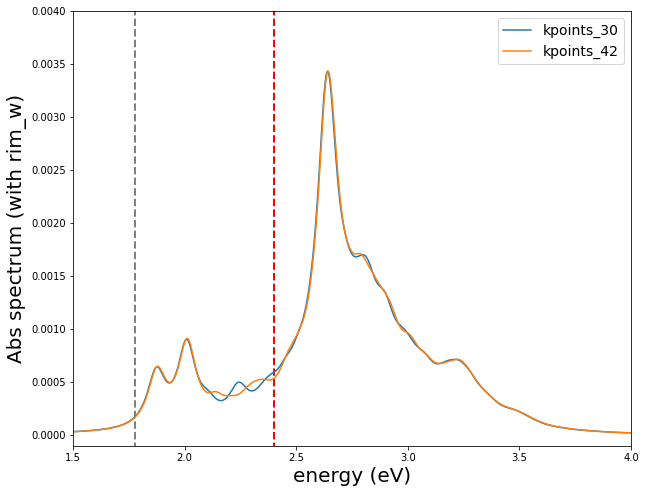

In [82]:
fig, ax = plt.subplots(figsize=(10, 8))

#for ind,k in enumerate(kpoints):
for ind in [1,2]:
    data = results[ind].data['eps_q1_diago_bse']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax.plot(energy,eps_im,label='kpoints_%s'%kpoints[ind]) 
ax.vlines(dft_gap,-1,10,linestyles='--',color='gray',linewidth=2)
ax.vlines(exp_gap,-1,10,linestyles='--',color='red',linewidth=2)
ax.set_xlim(1.5,4)
ax.set_ylim(-1e-4,4e-3)
ax.set_ylabel('Abs spectrum (with rim_w)',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

We observe that the rim_w improves the convergence even at the BSE level. Within this option the 30x30x1
result is very similar to the 42x42x1, apart from small ripples after the first two peaks

Before going ahead with further investigations we can check if it is possible to improve the efficiency of the computation
by adjusting some parameters (and/or by using the haydock solver instead of the diagonalization). We perform this analysis
in 30x30x1 sampling. 

In [7]:
k = 30
run_dir = 'BSE_analysis/kpoints_%s-nbnds_250/'%k

RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 30. # Ha use this value for the BSENGexx variable
BndsRnXs = [1,250] # Polarization function bands
FFTGvecs = 30. # Ha 
elec_field = [1.,0.,0.]
BSEBands = [25,30]
energy_range = [0,4] # eV
energy_step = 1000
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=1,verbose=True,skip=False)
study.set_postprocessing_function(PP.yambo_parse_data)

 
inp = I.YamboInput('yambo -r -o b -k sex -y h',folder=run_dir)
inp.activate_RIM_W()   
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(BSEBands=BSEBands)
inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
inp.set_array_variables(BEnSteps=energy_step)
inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')     
idd = 'bse-bsebands_%s-%s-kpoints_%s_rimw-test'%(BSEBands[0],BSEBands[1],k)
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
    jobname=[idd,',ndb_em1d-ngsblkxp_6.0-bndsrnxp_250','ndb_rim_cutoff','ndb_dipoles-bnds_250'],reformat=False)

Initialize a Dataset with 1 parallel tasks


In [8]:
#study.runs[0]

In [9]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete job_out script: BSE_analysis/kpoints_30-nbnds_250/job_bse-bsebands_25-30-kpoints_30_rimw-test.out
delete folder: BSE_analysis/kpoints_30-nbnds_250/bse-bsebands_25-30-kpoints_30_rimw-test
run command: mpirun -np 32 yambo -F bse-bsebands_25-30-kpoints_30_rimw-test.in -J "bse-bsebands_25-30-kpoints_30_rimw-test,,ndb_em1d-ngsblkxp_6.0-bndsrnxp_250,ndb_rim_cutoff,ndb_dipoles-bnds_250" -C bse-bsebands_25-30-kpoints_30_rimw-test
slurm submit:  cd BSE_analysis/kpoints_30-nbnds_250/ ; sbatch job_bse-bsebands_25-30-kpoints_30_rimw-test.sh
computation bse-bsebands_25-30-kpoints_30_rimw-test is running...
computation bse-bsebands_25-30-kpoints_30_rimw-test ended
Run performed in 04m-23s
Task [0] ended 
 


In [10]:
data_ref = P.YamboOutputParser.from_file('BSE_analysis/kpoints_30-nbnds_250/bse-bsebands_25-30-kpoints_30_rimw/o-bse-bsebands_25-30-kpoints_30_rimw.eps_q1_diago_bse')
energy_ref = data_ref['eps_q1_diago_bse']['energy']
eps_im_ref = data_ref['eps_q1_diago_bse']['eps_imag']

Parse file BSE_analysis/kpoints_30-nbnds_250/bse-bsebands_25-30-kpoints_30_rimw/o-bse-bsebands_25-30-kpoints_30_rimw.eps_q1_diago_bse


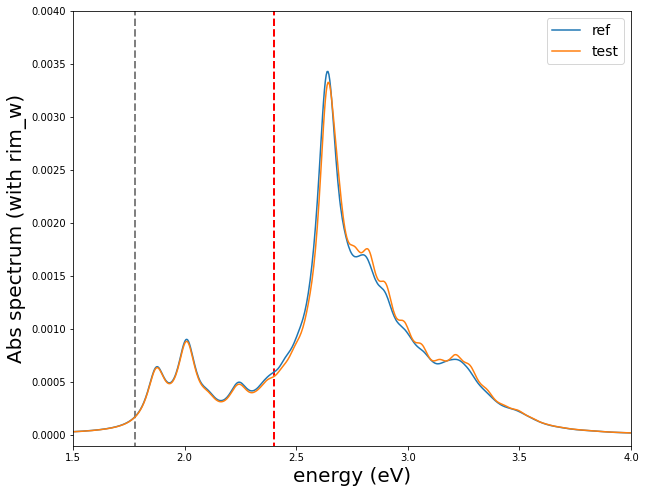

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))

data = results[0].data['eps_q1_haydock_bse']
energy = data['energy']
eps_im = data['eps_imag']
ax.plot(energy_ref,eps_im_ref,label='ref') 
ax.plot(energy,eps_im,label='test') 
ax.vlines(dft_gap,-1,10,linestyles='--',color='gray',linewidth=2)
ax.vlines(exp_gap,-1,10,linestyles='--',color='red',linewidth=2)
ax.set_xlim(1.5,4)
ax.set_ylim(-1e-4,4e-3)
ax.set_ylabel('Abs spectrum (with rim_w)',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

On the basis of this analysis we observe that
* The Haydock solver improved the efficiency of the evaluation of the spectrum and provides results identical to the direct diagonalization
* reducing the BSENGBlk w.r.t the size of the em1s reduces the time needed to build the BSE kernel. For instance BSENGBlk = 4.0 Ha provides
  indentical results w.r.t. the reference and also BSENGBlk = 3.0 Ha provides reliable results with minimal differences.

Using the improved parameters we test the influence of adding more bands in the abs spectrum.

We also build the JDOS at the DFT level to see which are the relevant bands in a given energy window.

In [4]:
k = 30
run_dir = 'BSE_analysis/kpoints_%s-nbnds_250/'%k

In [10]:
dft_data = P.YamboDftParser(os.path.join(run_dir,'SAVE','ns.db1'))

Parse file : BSE_analysis/kpoints_30-nbnds_250/SAVE/ns.db1


In [58]:
[a for a in range(22,26)]

[22, 23, 24, 25]

In [68]:
val,cond = [24,25],[26,27]
init1,final1 = [a for a in range(20,25)],[a for a in range(26,33)]

trans_val_cond = dft_data.get_transitions(initial=val,final=cond,set_scissor=scissor)
trans_ext1 = dft_data.get_transitions(initial=init1,final=final1,set_scissor=scissor)

dos = U.Dos()
dos.append(trans_val_cond.flatten(),minVal=1,maxVal=10,eta=5e-2,label='val_cond')
dos.append(trans_ext1.flatten(),minVal=1,maxVal=10,eta=5e-2,label='ext1')

(-0.1, 2.0)

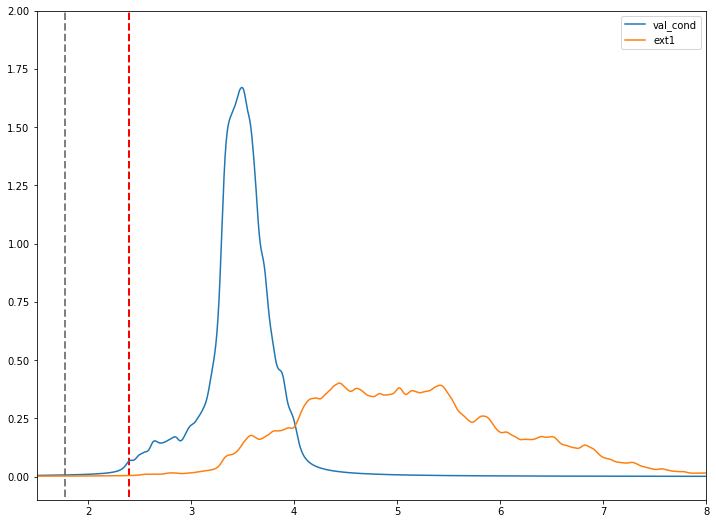

In [69]:
fig, ax = plt.subplots(figsize=(12, 9))
dos.plot(plt,rescale=False)
ax.vlines(dft_gap,-1,10,linestyles='--',color='gray',linewidth=2)
ax.vlines(exp_gap,-1,10,linestyles='--',color='red',linewidth=2)
ax.set_xlim(1.5,8)
ax.set_ylim(-0.1,2)

In [127]:
RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
BSENGBlk = 4.0 # Ha value of BSENGBlk (reduced w.r.t the NGBlkXs value)
EXXRLvcs = 30. # Ha use this value for the BSENGexx variable
BndsRnXs = [1,250] # Polarization function bands
FFTGvecs = 30. # Ha 
elec_field = [1.,0.,0.]
BSEBands = [[23,30],[21,32],[19,34]]
energy_range = [0,4] # eV
energy_step = 1000
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=3,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -r -o b -k sex -y h',folder=run_dir)
inp.activate_RIM_W()   
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
inp.set_array_variables(BEnSteps=energy_step)
inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')     
for bsebands in BSEBands:
    inp.set_array_variables(BSEBands=bsebands)
    idd = 'bse-bsebands_%s-%s-kpoints_%s_rimw'%(bsebands[0],bsebands[1],k)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
        jobname=[idd,',ndb_em1d-ngsblkxp_6.0-bndsrnxp_250','ndb_rim_cutoff','ndb_dipoles-bnds_250'],reformat=False)

Initialize a Dataset with 3 parallel tasks


In [133]:
#study.runs[0]

In [135]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1, 2]] 

Run the task [0, 1, 2] 
Skip the run of bse-bsebands_23-30-kpoints_30_rimwSkip the run of
 bse-bsebands_21-32-kpoints_30_rimw
Skip the run of bse-bsebands_19-34-kpoints_30_rimw
Task [0, 1, 2] ended 
 


In [136]:
data_ref = P.YamboOutputParser.from_file('BSE_analysis/kpoints_30-nbnds_250/bse-bsebands_25-30-kpoints_30_rimw/o-bse-bsebands_25-30-kpoints_30_rimw.eps_q1_diago_bse')
energy_ref = data_ref['eps_q1_diago_bse']['energy']
eps_im_ref = data_ref['eps_q1_diago_bse']['eps_imag']

Parse file BSE_analysis/kpoints_30-nbnds_250/bse-bsebands_25-30-kpoints_30_rimw/o-bse-bsebands_25-30-kpoints_30_rimw.eps_q1_diago_bse


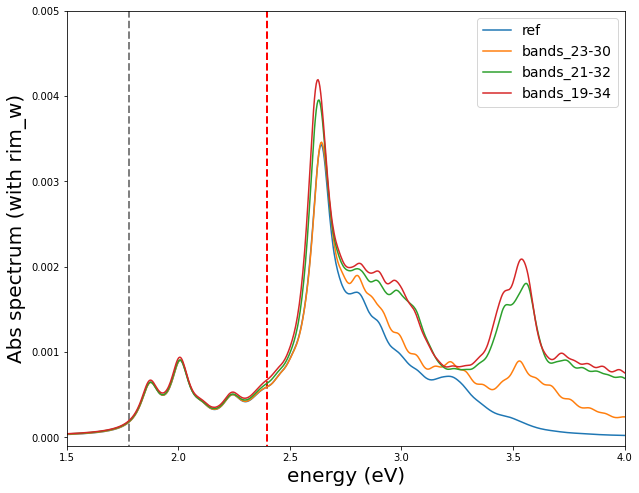

In [139]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(energy_ref,eps_im_ref,label='ref')
for ind,b in enumerate(BSEBands):
    data = results[ind].data['eps_q1_haydock_bse']
    energy = data['energy']
    eps_im = data['eps_imag']
    ax.plot(energy,eps_im,label='bands_%s-%s'%(b[0],b[1])) 
ax.vlines(dft_gap,-1,10,linestyles='--',color='gray',linewidth=2)
ax.vlines(exp_gap,-1,10,linestyles='--',color='red',linewidth=2)
ax.set_xlim(1.5,4)
ax.set_ylim(-1e-4,5e-3)
ax.set_ylabel('Abs spectrum (with rim_w)',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

## BSE analysis of the XUV spectrum

We compute the absorption spectrum due to the semicore electrons at the BSE level.

In this analysis we restric the transition from the bands 3 to 8 that should correspond
to the 6 4p states of the Mo atom (with the j=1/2 and j=3/2 states splitted by the SOC) to
the conduction bands 27 and 28.

We test the convergence of the results w.r.t the BSENGBkl paramaeter

In [7]:
dft_gap = 1.78
exp_gap = 2.4 # value to be checked
scissor = exp_gap-dft_gap # eV
print('scissor',scissor)

scissor 0.6199999999999999


In [7]:
k = 18 #30
run_dir = 'BSE_analysis/kpoints_%s-nbnds_250/'%k

RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
BSENGBlk = [3.] # [3.,4.] # Ha  values of the BSENGBlk variable
EXXRLvcs = 30. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha 
elec_field = [1.,0.,0.]
BEnRange = [0,50] # eV
BEnSteps = 1000
BSEBands = [3,44]
BSEHoleBands = [3,8] #[3,12] 
BSEElecBands = [27,44] #[27,38] #[27,34] #[27,30] #[27,28]
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=2,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

 
inp = I.YamboInput('yambo -r -o b -k sex -y h',folder=run_dir)
#inp.activate_RIM_W()   
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(BSEBands=BSEBands,BSEHoleBands=BSEHoleBands,BSEElecBands=BSEElecBands)
inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping)
inp.set_array_variables(BEnSteps=BEnSteps)
inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t') #  1 node with 32 mpi and 1 omp  
#inp.set_scalar_variables(BS_CPU='32.2.1',BS_ROLEs= 'k.eh.t') #  2 nodes with 32 mpi and 1 omp      
for bsengblk in BSENGBlk:
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=bsengblk,FFTGvecs=FFTGvecs)
    #idd = 'bse-xuv-holebands_%s-%s-elecbands_%s-%s-bsengblk_%s'%(BSEHoleBands[0],BSEHoleBands[1],BSEElecBands[0],BSEElecBands[1],bsengblk)
    idd = 'bse-xuv-holebands_%s-%s-elecbands_%s-%s-bsengblk_%s_norimw'%(BSEHoleBands[0],BSEHoleBands[1],BSEElecBands[0],BSEElecBands[1],bsengblk)    
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
    jobname=[idd,',ndb_em1d-ngsblkxp_6.0-bndsrnxp_250','ndb_rim_cutoff','ndb_dipoles-bnds_250'],reformat=False)

Initialize a Dataset with 2 parallel tasks


In [8]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'BSE_analysis/kpoints_18-nbnds_250/',
 'num_tasks': 2,
 'verbose': True,
 'skip': True,
 'input': {'args': 'yambo -r -o b -k sex -y h',
  'folder': 'BSE_analysis/kpoints_18-nbnds_250/',
  'filename': 'yambo.in',
  'arguments': ['rim_cut', 'bse', 'optics', 'bss', 'photolum'],
  'variables': {'DIP_Threads': [0.0, ''],
   'X_Threads': [0.0, ''],
   'K_Threads': [0.0, ''],
   'RandQpts': [5000000.0, ''],
   'RandGvec': [100, 'RL'],
   'CUTRadius': [0.0, ''],
   'CUTCylLen': [0.0, ''],
   'CUTwsGvec': [0.7, ''],
   'BSENGexx': [30.0, 'Ha'],
   'BSENGBlk': [3.0, 'Ha'],
   'BEnSteps': [1000, ''],
   'BSHayTrs': [-0.02, ''],
   'CUTGeo': 'slab z',
   'BSKmod': 'SEX',
   'BSEmod': 'resonant',
   'BSSmod': 'h',
   'BSEprop': 'abs',
   'BSEdips': 'none',
   'CUTBox': [[0.0, 0.0, 0.0], ''],
   'BSEQptR': [[1, 1], ''],
   'BSEBands': [[3, 44], ''],
   'BEnRange': [[0, 50], 'eV'],
   'BDmRange': [[0.05, 0.05], 'eV'],
   'BLongDir': [[1.0, 0.0, 0.0], ''],
   'RandGvec

In [9]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo -F bse-xuv-holebands_3-8-elecbands_27-44-bsengblk_3.0_norimw.in -J "bse-xuv-holebands_3-8-elecbands_27-44-bsengblk_3.0_norimw,,ndb_em1d-ngsblkxp_6.0-bndsrnxp_250,ndb_rim_cutoff,ndb_dipoles-bnds_250" -C bse-xuv-holebands_3-8-elecbands_27-44-bsengblk_3.0_norimw
slurm submit:  cd BSE_analysis/kpoints_18-nbnds_250/ ; sbatch job_bse-xuv-holebands_3-8-elecbands_27-44-bsengblk_3.0_norimw.sh
computation bse-xuv-holebands_3-8-elecbands_27-44-bsengblk_3.0_norimw is running...
computation bse-xuv-holebands_3-8-elecbands_27-44-bsengblk_3.0_norimw ended
Run performed in 02h-31m
Task [0] ended 
 


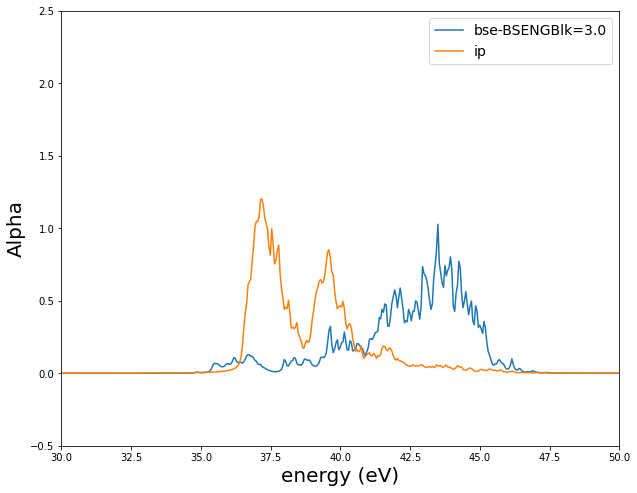

In [10]:
# 18x18x1 HoleBands = [3,8] ElecBands = [27,44] for BSENGBlk=3.0 WITHOUT THE RIM_W
fig, ax = plt.subplots(figsize=(10, 8))

for ind,r in results.items():
    alpha = r.data['alpha_q1_haydock_bse']
    energy = alpha['energy']
    alpha_im = alpha['alpha_imag']
    alpha_o_im = alpha['alpha_o_imag']
    ax.plot(energy,alpha_im,label='bse-BSENGBlk=%s'%BSENGBlk[ind])
    ax.plot(energy,alpha_o_im,label='ip')
ax.set_ylabel('Alpha',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_xlim(30,50)
ax.set_ylim(-0.5,2.5)
ax.legend(fontsize=14)

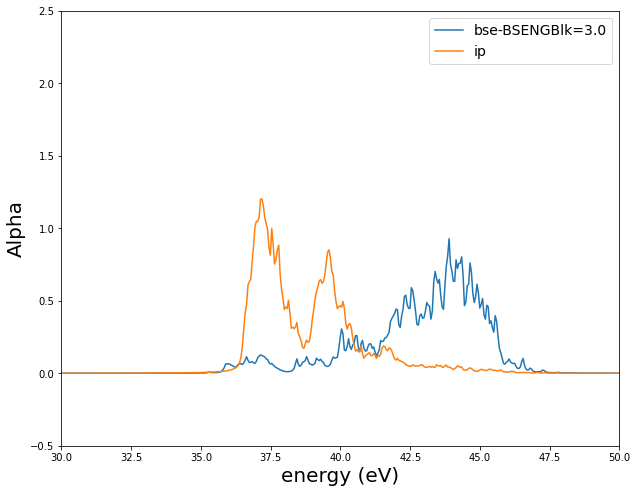

In [26]:
# 18x18x1 HoleBands = [3,12] ElecBands = [27,44] for BSENGBlk=3.0
fig, ax = plt.subplots(figsize=(10, 8))

for ind,r in results.items():
    alpha = r.data['alpha_q1_haydock_bse']
    energy = alpha['energy']
    alpha_im = alpha['alpha_imag']
    alpha_o_im = alpha['alpha_o_imag']
    ax.plot(energy,alpha_im,label='bse-BSENGBlk=%s'%BSENGBlk[ind])
    ax.plot(energy,alpha_o_im,label='ip')
ax.set_ylabel('Alpha',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_xlim(30,50)
ax.set_ylim(-0.5,2.5)
ax.legend(fontsize=14)

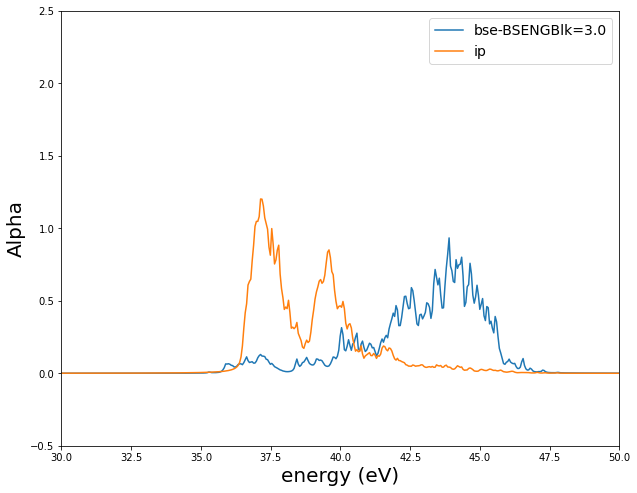

In [16]:
# 18x18x1 HoleBands = [3,8] ElecBands = [27,44] for BSENGBlk=3.0
fig, ax = plt.subplots(figsize=(10, 8))

for ind,r in results.items():
    alpha = r.data['alpha_q1_haydock_bse']
    energy = alpha['energy']
    alpha_im = alpha['alpha_imag']
    alpha_o_im = alpha['alpha_o_imag']
    ax.plot(energy,alpha_im,label='bse-BSENGBlk=%s'%BSENGBlk[ind])
    ax.plot(energy,alpha_o_im,label='ip')
ax.set_ylabel('Alpha',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_xlim(30,50)
ax.set_ylim(-0.5,2.5)
ax.legend(fontsize=14)

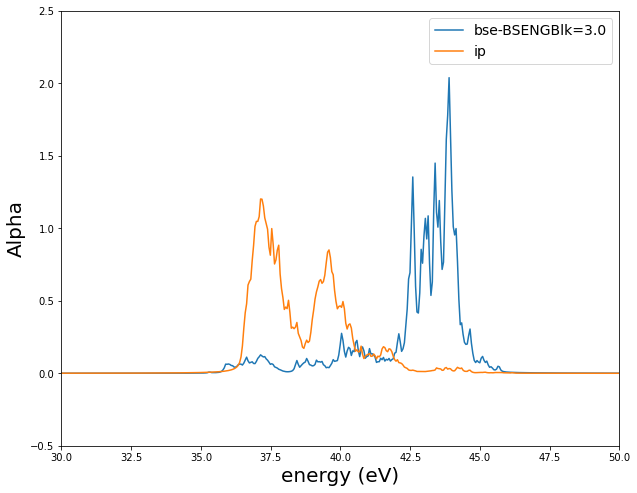

In [8]:
# 18x18x1 HoleBands = [3,8] ElecBands = [27,38] for BSENGBlk=3.0
fig, ax = plt.subplots(figsize=(10, 8))

for ind,r in results.items():
    alpha = r.data['alpha_q1_haydock_bse']
    energy = alpha['energy']
    alpha_im = alpha['alpha_imag']
    alpha_o_im = alpha['alpha_o_imag']
    ax.plot(energy,alpha_im,label='bse-BSENGBlk=%s'%BSENGBlk[ind])
    ax.plot(energy,alpha_o_im,label='ip')
ax.set_ylabel('Alpha',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_xlim(30,50)
ax.set_ylim(-0.5,2.5)
ax.legend(fontsize=14)

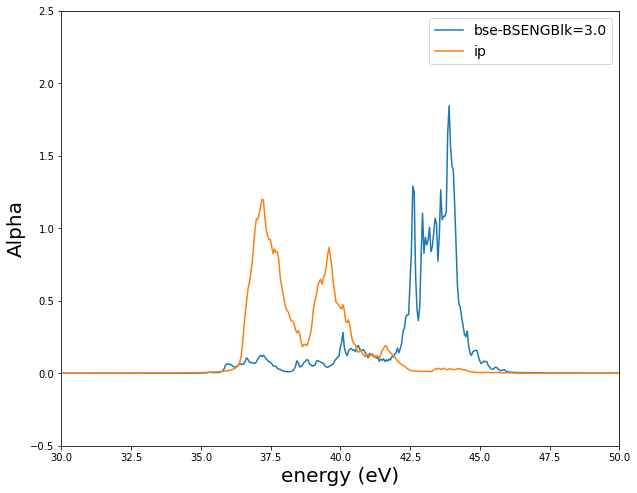

In [11]:
# HoleBands = [3,8] ElecBands = [27,38] for BSENGBlk=3.0
fig, ax = plt.subplots(figsize=(10, 8))

for ind,r in results.items():
    alpha = r.data['alpha_q1_haydock_bse']
    energy = alpha['energy']
    alpha_im = alpha['alpha_imag']
    alpha_o_im = alpha['alpha_o_imag']
    ax.plot(energy,alpha_im,label='bse-BSENGBlk=%s'%BSENGBlk[ind])
    ax.plot(energy,alpha_o_im,label='ip')
ax.set_ylabel('Alpha',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_xlim(30,50)
ax.set_ylim(-0.5,2.5)
ax.legend(fontsize=14)

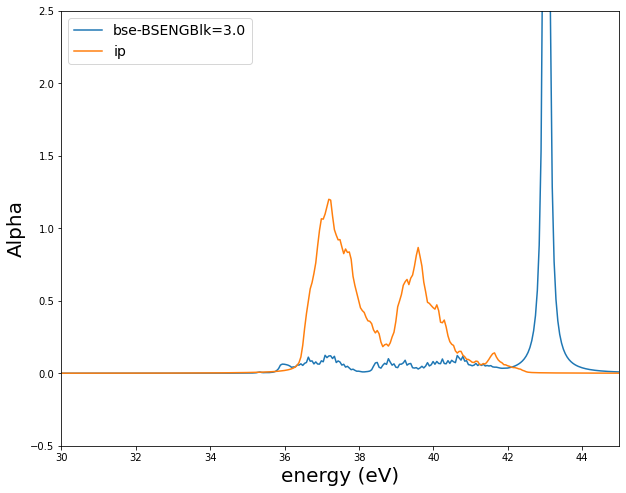

In [8]:
# HoleBands = [3,8] ElecBands = [27,34] for BSENGBlk=3.0
fig, ax = plt.subplots(figsize=(10, 8))

for ind,r in results.items():
    alpha = r.data['alpha_q1_haydock_bse']
    energy = alpha['energy']
    alpha_im = alpha['alpha_imag']
    alpha_o_im = alpha['alpha_o_imag']
    ax.plot(energy,alpha_im,label='bse-BSENGBlk=%s'%BSENGBlk[ind])
    ax.plot(energy,alpha_o_im,label='ip')
ax.set_ylabel('Alpha',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_xlim(30,45)
ax.set_ylim(-0.5,2.5)
ax.legend(fontsize=14)

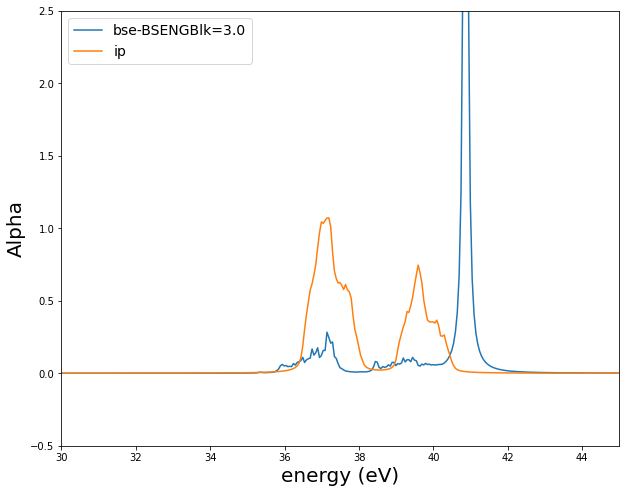

In [20]:
# HoleBands = [3,8] ElecBands = [27,30] for BSENGBlk=3.0
fig, ax = plt.subplots(figsize=(10, 8))

for ind,r in results.items():
    alpha = r.data['alpha_q1_haydock_bse']
    energy = alpha['energy']
    alpha_im = alpha['alpha_imag']
    alpha_o_im = alpha['alpha_o_imag']
    ax.plot(energy,alpha_im,label='bse-BSENGBlk=%s'%BSENGBlk[ind])
    ax.plot(energy,alpha_o_im,label='ip')
ax.set_ylabel('Alpha',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_xlim(30,45)
ax.set_ylim(-0.5,2.5)
ax.legend(fontsize=14)

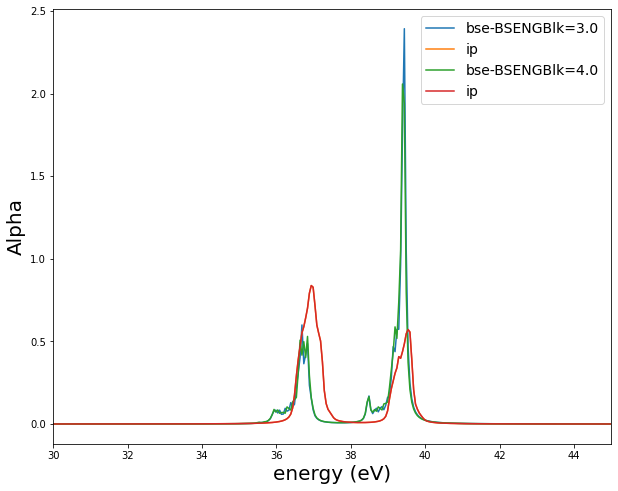

In [15]:
# HoleBands = [3,8] ElecBands = [27,28] for various BSENGBlk
fig, ax = plt.subplots(figsize=(10, 8))

for ind,r in results.items():
    alpha = r.data['alpha_q1_haydock_bse']
    energy = alpha['energy']
    alpha_im = alpha['alpha_imag']
    alpha_o_im = alpha['alpha_o_imag']
    ax.plot(energy,alpha_im,label='bse-BSENGBlk=%s'%BSENGBlk[ind])
    ax.plot(energy,alpha_o_im,label='ip')
ax.set_ylabel('Alpha',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_xlim(30,45)
ax.legend(fontsize=14)

### XUV spectra with the Hartree Kernel

In [12]:
k = 18 #30
run_dir = 'BSE_analysis/kpoints_%s-nbnds_250/'%k

RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
BSENGBlk = 3. # Ha  values of the BSENGBlk variable
EXXRLvcs = 30. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha 
elec_field = [1.,0.,0.]
BEnRange = [0,50] # eV
BEnSteps = 1000
BSEBands = [3,44]
BSEHoleBands = [3,8] 
BSEElecBands = [27,44] 
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=2,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

 
inp = I.YamboInput('yambo -r -o b -k hartree -y h',folder=run_dir)
inp.activate_RIM_W()   
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(BSEBands=BSEBands,BSEHoleBands=BSEHoleBands,BSEElecBands=BSEElecBands)
inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping)
inp.set_array_variables(BEnSteps=BEnSteps)
inp.set_scalar_variables(DBsIOoff='BS')
inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t') #  1 node with 32 mpi and 1 omp  
inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
idd = 'bse-xuv-Hartree-holebands_%s-%s-elecbands_%s-%s'%(BSEHoleBands[0],BSEHoleBands[1],BSEElecBands[0],BSEElecBands[1])    
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
jobname=[idd,',ndb_em1d-ngsblkxp_6.0-bndsrnxp_250','ndb_rim_cutoff','ndb_dipoles-bnds_250'],reformat=False)

Initialize a Dataset with 2 parallel tasks


In [13]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'BSE_analysis/kpoints_18-nbnds_250/',
 'num_tasks': 2,
 'verbose': True,
 'skip': True,
 'input': {'args': 'yambo -r -o b -k hartree -y h',
  'folder': 'BSE_analysis/kpoints_18-nbnds_250/',
  'filename': 'yambo.in',
  'arguments': ['rim_cut', 'bse', 'optics', 'bss', 'photolum', 'RIM_W'],
  'variables': {'DIP_Threads': [0.0, ''],
   'X_Threads': [0.0, ''],
   'K_Threads': [0.0, ''],
   'RandQpts': [5000000.0, ''],
   'RandGvec': [100, 'RL'],
   'CUTRadius': [0.0, ''],
   'CUTCylLen': [0.0, ''],
   'CUTwsGvec': [0.7, ''],
   'BSENGexx': [30.0, 'Ha'],
   'BEnSteps': [1000, ''],
   'BSHayTrs': [-0.02, ''],
   'CUTGeo': 'slab z',
   'BSKmod': 'HARTREE',
   'BSEmod': 'resonant',
   'BSSmod': 'h',
   'BSEprop': 'abs',
   'BSEdips': 'none',
   'CUTBox': [[0.0, 0.0, 0.0], ''],
   'BSEQptR': [[1, 1], ''],
   'BSEBands': [[3, 44], ''],
   'BEnRange': [[0, 50], 'eV'],
   'BDmRange': [[0.05, 0.05], 'eV'],
   'BLongDir': [[1.0, 0.0, 0.0], ''],
   'RandGvecW': [10, 'R

In [14]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of bse-xuv-Hartree-holebands_3-8-elecbands_27-44
Task [0] ended 
 


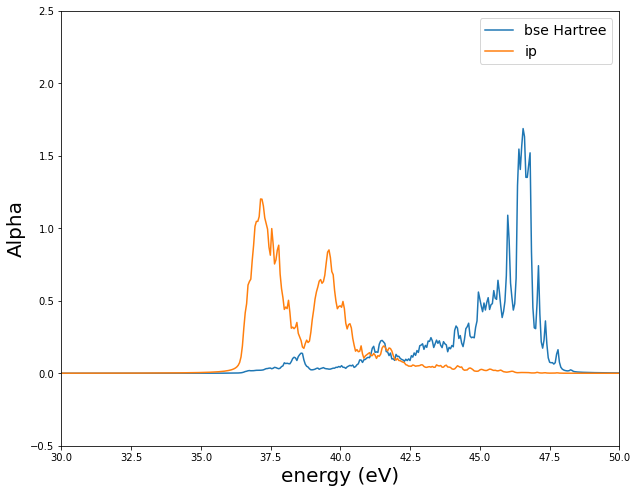

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,r in results.items():
    alpha = r.data['alpha_q1_haydock_bse']
    energy = alpha['energy']
    alpha_im = alpha['alpha_imag']
    alpha_o_im = alpha['alpha_o_imag']
    ax.plot(energy,alpha_im,label='bse Hartree')
    ax.plot(energy,alpha_o_im,label='ip')
ax.set_ylabel('Alpha',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_xlim(30,50)
ax.set_ylim(-0.5,2.5)
ax.legend(fontsize=14)

### XUV spectrum in the IP regime - Analysis of the contribution of the empty bands

WE compute the XUV spectrum in the IP regime and we select a limited range of empty bands
to see which ones contribute most to the IP absorption peaks.

In [4]:
dft_gap = 1.78
exp_gap = 2.4 # value to be checked
scissor = exp_gap-dft_gap # eV
print('scissor',scissor)

scissor 0.6199999999999999


In [27]:
k = 18 #30
run_dir = 'BSE_analysis/kpoints_%s-nbnds_250/'%k

RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
BSENGBlk = [3.] # [3.,4.] # Ha  values of the BSENGBlk variable
EXXRLvcs = 30. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha 
elec_field = [1.,0.,0.]
BEnRange = [0,50] # eV
BEnSteps = 1000
BSEBands = [3,44]
BSEHoleBands = [3,12] #[3,8]
BSEElecBands = [[27,28],[29,30],[31,34],[35,36],[37,38]]
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=2,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

 
inp = I.YamboInput('yambo -r -o b',folder=run_dir)
inp.activate_RIM_W()   
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping)
inp.set_array_variables(BEnSteps=BEnSteps)
inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t') #  1 node with 32 mpi and 1 omp  
#inp.set_scalar_variables(BS_CPU='32.2.1',BS_ROLEs= 'k.eh.t') #  2 nodes with 32 mpi and 1 omp      
inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
for elecbands in BSEElecBands:
    inp.set_array_variables(BSEBands=BSEBands,BSEHoleBands=BSEHoleBands,BSEElecBands=elecbands)
    idd = 'ip-xuv-holebands_%s-%s-elecbands_%s-%s'%(BSEHoleBands[0],BSEHoleBands[1],elecbands[0],elecbands[1])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
    jobname=[idd,'ndb_rim_cutoff','ndb_dipoles-bnds_250'],reformat=False)

Initialize a Dataset with 2 parallel tasks


In [28]:
#study.runs[2]

In [29]:
results = study.run()

Run the selection [0, 1, 2, 3, 4] with the parallel task_groups [[0, 1], [2, 3], [4]] 

Run the task [0, 1] 
Skip the run of ip-xuv-holebands_3-12-elecbands_27-28
Skip the run of ip-xuv-holebands_3-12-elecbands_29-30
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of ip-xuv-holebands_3-12-elecbands_31-34
Skip the run of ip-xuv-holebands_3-12-elecbands_35-36
Task [2, 3] ended 
 
Run the task [4] 
Skip the run of ip-xuv-holebands_3-12-elecbands_37-38
Task [4] ended 
 


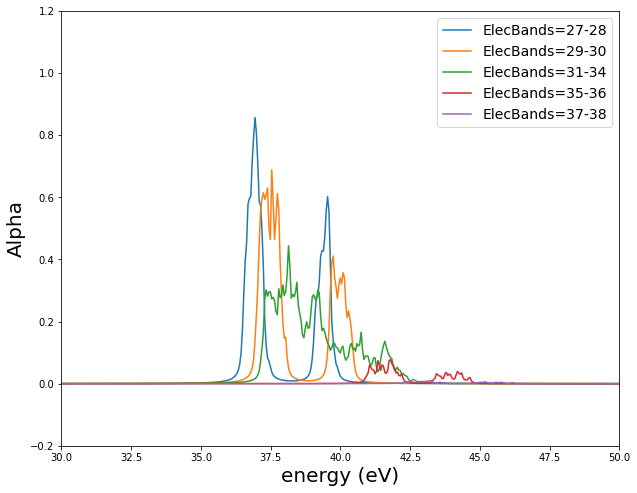

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,r in results.items():
    alpha = r.data['alpha_q1_IP']
    energy = alpha['energy']
    alpha_im = alpha['alpha_imag']
    ax.plot(energy,alpha_im,label='ElecBands=%s-%s'%(BSEElecBands[ind][0],BSEElecBands[ind][1]))
ax.set_ylabel('Alpha',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_xlim(30,50)
ax.set_ylim(-0.2,1.2)
ax.legend(fontsize=14)

## Plot

__Bands__

In [62]:
G = [0.,0.,0.]
Kp = [1./3.,1./np.sqrt(3),0.]
Mp = [0.,1./np.sqrt(3),0.]
high_sym = {'G':G,'K':Kp,'M':Mp}

In [63]:
bands = U.BandStructure.from_Pw('DFT_analysis/bands.save/data-file-schema.xml',high_sym_points=high_sym,set_scissor=0.62)

Apply a scissor of 0.62 eV


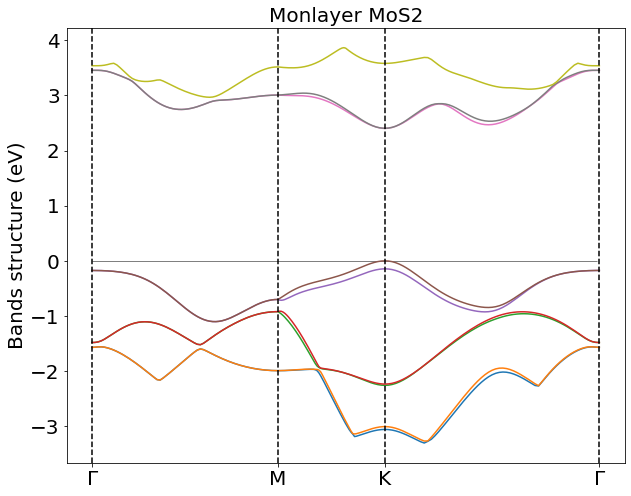

In [65]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 8))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(20,29)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_title('Monlayer MoS2',size=20)

plt.savefig(fname='Plot/Monolayer_Band_structure.jpg',format='jpg',bbox_inches = "tight")

__Optical absorption__

In [66]:
dft_gap = 1.78
exp_gap = 2.4 # value to be checked
scissor = exp_gap-dft_gap # eV
print('scissor',scissor)

scissor 0.6199999999999999


Parse file BSE_analysis/kpoints_30-nbnds_250/bse-bsebands_25-30-kpoints_30_rimw/o-bse-bsebands_25-30-kpoints_30_rimw.alpha_q1_diago_bse


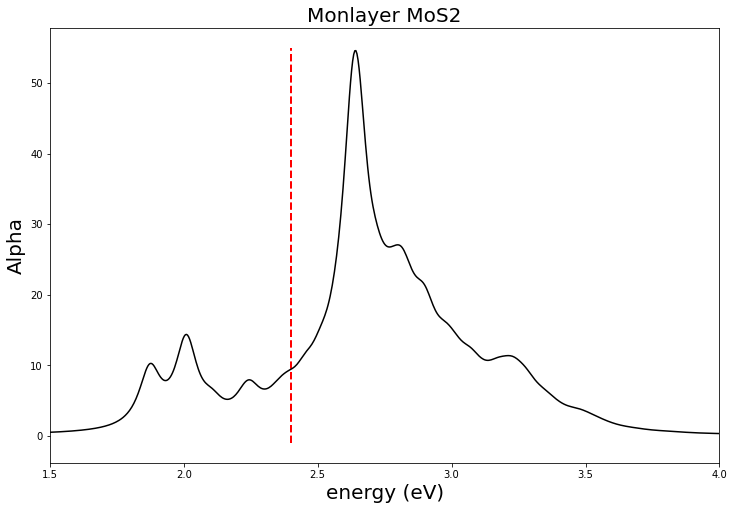

In [68]:
data = P.YamboOutputParser.from_file('BSE_analysis/kpoints_30-nbnds_250/bse-bsebands_25-30-kpoints_30_rimw/o-bse-bsebands_25-30-kpoints_30_rimw.alpha_q1_diago_bse')
energy = data['alpha_q1_diago_bse']['energy']
eps_im = data['alpha_q1_diago_bse']['eps_imag']

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(energy,eps_im,color='black') 
ax.vlines(exp_gap,-1,55,linestyles='--',color='red',linewidth=2)
ax.set_xlim(1.5,4)
ax.set_ylabel('Alpha',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_title('Monlayer MoS2',size=20)
#ax.legend(fontsize=14)

plt.savefig(fname='Plot/Monolayer_Absorption_optical.jpg',format='jpg',bbox_inches = "tight")

__XUV Absorption__

In [48]:
full = P.YamboOutputParser.from_file('BSE_analysis/kpoints_18-nbnds_250/bse-xuv-holebands_3-8-elecbands_27-44-bsengblk_3.0/o-bse-xuv-holebands_3-8-elecbands_27-44-bsengblk_3.0.alpha_q1_haydock_bse')
hartree = P.YamboOutputParser.from_file('BSE_analysis/kpoints_18-nbnds_250/bse-xuv-Hartree-holebands_3-8-elecbands_27-44/o-bse-xuv-Hartree-holebands_3-8-elecbands_27-44.alpha_q1_haydock_bse')

Parse file BSE_analysis/kpoints_18-nbnds_250/bse-xuv-holebands_3-8-elecbands_27-44-bsengblk_3.0/o-bse-xuv-holebands_3-8-elecbands_27-44-bsengblk_3.0.alpha_q1_haydock_bse
Parse file BSE_analysis/kpoints_18-nbnds_250/bse-xuv-Hartree-holebands_3-8-elecbands_27-44/o-bse-xuv-Hartree-holebands_3-8-elecbands_27-44.alpha_q1_haydock_bse


In [49]:
data_full, data_hartree = full['alpha_q1_haydock_bse'], hartree['alpha_q1_haydock_bse']

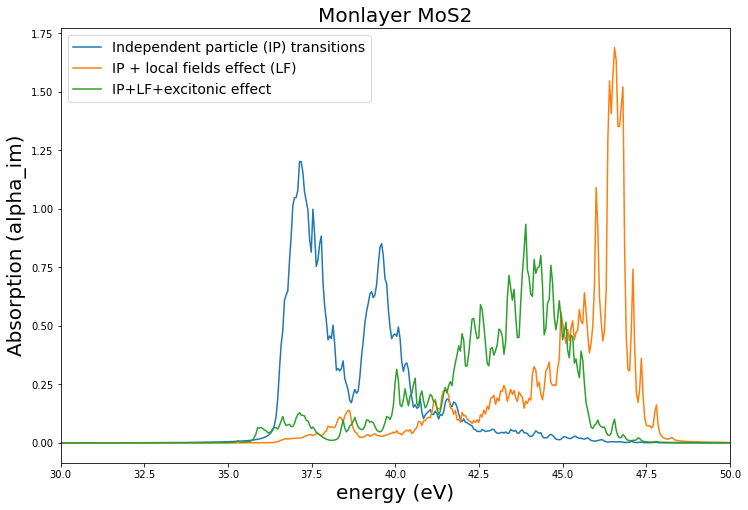

In [69]:
fig, ax = plt.subplots(figsize=(12, 8))
energy_full, energy_hartree = data_full['energy'], data_hartree['energy']
alpha_full_im, alpha_hartree_im = data_full['alpha_imag'], data_hartree['alpha_imag']
alpha_o_im = data_full['alpha_o_imag']
ax.plot(energy_full,alpha_o_im,label='Independent particle (IP) transitions')
ax.plot(energy_hartree,alpha_hartree_im,label='IP + local fields effect (LF)')
ax.plot(energy_full,alpha_full_im,label='IP+LF+excitonic effect')
ax.set_ylabel('Absorption (alpha_im)',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_xlim(30,50)
ax.legend(fontsize=14)
ax.set_title('Monlayer MoS2',size=20)


plt.savefig(fname='Plot/Monolayer_Absorption_xuv.jpg',format='jpg',bbox_inches = "tight")

## Analysis of the excitonic dispersion

We compute the excitonic dispersion on top of the GW quasi particles.

We work on the 30x30x1 using the QP built on the 18x18x1 that are interpolated by Yambo.

### Analysis of the interpolated ndbs

First of all we perform a IP calculation to compute the interpolated QP ndb, and we check the shape
of the interpolated bands.

We work in the GW folder where all the needed nds have been already computed

In [7]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,activate_BeeOND=True)
#code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [8]:
run_dir = 'GW_analysis/kpoints_30-nbnds_250-sg15/'

RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 40. # Ha use this value for the BSENGexx variable
BndsRnXs = [1,250] # Polarization function bands
FFTGvecs = 30. # Ha 
elec_field = [1.,0.,0.]
BSEBands = [25,28]
energy_range = [0,4] # eV
energy_step = 1000
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=1,verbose=True,skip=False)
study.set_postprocessing_function(PP.yambo_parse_data)

 
inp = I.YamboInput('yambo -r -rw -o b',folder=run_dir) # -k sex -y h
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
inp.set_array_variables(BLongDir=elec_field)
inp.set_array_variables(BSEBands=BSEBands)
inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
inp.set_array_variables(BEnSteps=energy_step)
inp.set_scalar_variables(BSEmod='casual')
inp.set_scalar_variables(KfnQPdb='E < ndbs/ndb.QP-kpoints_18 ubi')
inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')     
idd = 'ip-bse-bsebands_%s-%s'%(BSEBands[0],BSEBands[1])
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=[idd,',ndbs'],reformat=False)

Initialize a Dataset with 1 parallel tasks


In [8]:
inp

{'args': 'yambo -r -rw -o b',
 'folder': 'GW_analysis/kpoints_30-nbnds_250-sg15/',
 'filename': 'yambo.in',
 'arguments': ['rim_cut', 'rim_w', 'bse', 'optics', 'photolum'],
 'variables': {'DIP_Threads': [0.0, ''],
  'X_Threads': [0.0, ''],
  'K_Threads': [0.0, ''],
  'RandQpts': [5000000.0, ''],
  'RandGvec': [100, 'RL'],
  'RandGvecW': [10, 'RL'],
  'CUTRadius': [0.0, ''],
  'CUTCylLen': [0.0, ''],
  'CUTwsGvec': [0.7, ''],
  'BSENGexx': [40.0, 'Ha'],
  'BEnSteps': [1000, ''],
  'rimw_type': 'default',
  'CUTGeo': 'slab z',
  'BSKmod': 'IP',
  'BSEmod': 'casual',
  'BSEprop': 'abs',
  'BSEdips': 'none',
  'CUTBox': [[0.0, 0.0, 0.0], ''],
  'BSEQptR': [[1, 1], ''],
  'BSEBands': [[25, 28], ''],
  'BEnRange': [[0, 4], 'eV'],
  'BDmRange': [[0.05, 0.05], 'eV'],
  'BLongDir': [[1.0, 0.0, 0.0], ''],
  'BSENGBlk': [3.0, 'Ha'],
  'FFTGvecs': [30.0, 'Ha'],
  'KfnQPdb': 'E < ndbs/ndb.QP-kpoints_18 ubi',
  'BS_CPU': '32.1.1',
  'BS_ROLEs': 'k.eh.t'}}

In [9]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete job_out script: GW_analysis/kpoints_30-nbnds_250-sg15/job_ip-bse-bsebands_25-28.out
delete folder: GW_analysis/kpoints_30-nbnds_250-sg15/ip-bse-bsebands_25-28
run command: mpirun -np 32 yambo -F ip-bse-bsebands_25-28.in -J "ip-bse-bsebands_25-28,,ndbs" -C ip-bse-bsebands_25-28
slurm submit:  cd GW_analysis/kpoints_30-nbnds_250-sg15/ ; sbatch job_ip-bse-bsebands_25-28.sh
computation ip-bse-bsebands_25-28 is running...
computation ip-bse-bsebands_25-28 ended
Run performed in 03s
Task [0] ended 
 


We check the interpolated ndb by performing a band calculation

In [9]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #fastnodes
                memory='124000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
ypp_code = C.YamboCalculator(rr,executable='ypp',activate_BeeOND=True) 
#ypp_code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [10]:
ndbQP = 'ip-bse-bsebands_25-28/ndb.QP_interpolated'

In [11]:
# with BANDS_kpts

band_range = [25,28]
bands_step = 50

# in crystal coordinates
G = [0.,0.,0.]
Kp = [1./3.,1./3.,0.]
Mp = [0.,0.5,0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path
path = [G,Mp,Kp,G]

study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True)

inp = I.YamboInput(args='mpirun -np 1 ypp -s b -V qp',folder=run_dir,filename='ypp.in')
inp.set_array_variables(BANDS_bands=band_range,BANDS_steps=bands_step,BANDS_kpts=path)
inp.set_scalar_variables(cooIn='rlu',cooOut='rlu')

idd = 'ypp_bands_gw-interp'
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [10,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [10,'']
inp['variables']['GfnQPdb']= 'E < %s'%ndbQP
study.append_run(id=idd,input=inp,runner=ypp_code,skip=False)

Initialize a Dataset with 2 parallel tasks


In [13]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'GW_analysis/kpoints_30-nbnds_250-sg15/',
 'num_tasks': 2,
 'verbose': True,
 'input': {'args': 'mpirun -np 1 ypp -s b -V qp',
  'folder': 'GW_analysis/kpoints_30-nbnds_250-sg15/',
  'filename': 'ypp.in',
  'arguments': [],
  'variables': {'INTERP_Shell_Fac': [10, ''],
   'INTERP_NofNN': [1.0, ''],
   'OutputAlat': [0.0, ''],
   'BANDS_steps': [50, ''],
   'GfnQP_INTERP_NN': [1.0, ''],
   'GfnQP_INTERP_shells': [10, ''],
   'GfnQP_Wv_E': [0.0, 'eV'],
   'GfnQP_Wv_dos': [0.0, 'eV'],
   'GfnQP_Wc_E': [0.0, 'eV'],
   'GfnQP_Wc_dos': [0.0, 'eV'],
   'PROJECT_mode': 'none',
   'INTERP_mode': 'BOLTZ',
   'cooIn': 'rlu',
   'cooOut': 'rlu',
   'CIRCUIT_E_DB_path': 'none',
   'GfnQPdb': 'E < ip-bse-bsebands_25-28/ndb.QP_interpolated',
   'GfnQP_DbGd_INTERP_mode': 'BOLTZ',
   'GfnQP_Z': [(1+0j), ''],
   'BANDS_bands': [[25, 28], ''],
   'GfnQP_E': [[0.0, 1.0, 1.0], ''],
   'GfnQP_Wv': [[0.0, 0.0, 0.0], ''],
   'GfnQP_Wc': [[0.0, 0.0, 0.0], ''],
   'BANDS_kpts': 

In [14]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete job_out script: GW_analysis/kpoints_30-nbnds_250-sg15/job_ypp_bands_gw-interp.out
delete folder: GW_analysis/kpoints_30-nbnds_250-sg15/ypp_bands_gw-interp
run command: mpirun -np 16 ypp -F ypp_bands_gw-interp.in -J ypp_bands_gw-interp -C ypp_bands_gw-interp
slurm submit:  cd GW_analysis/kpoints_30-nbnds_250-sg15/ ; sbatch job_ypp_bands_gw-interp.sh
computation ypp_bands_gw-interp is running...
computation ypp_bands_gw-interp ended
Run performed in 04s
Task [0] ended 
 


In [15]:
bands_interp = U.BandStructure.from_Ypp(results[0],high_sym,suffix='bands_interpolated')
bands_gw = U.BandStructure.from_Ypp_file('GW_analysis/kpoints_18-nbnds_250-sg15/ypp_bands_gw_boltz-Gterm/o-ypp_bands_gw_boltz-Gterm.bands_interpolated')

We show the GW correction for the valence and conduction bands

Text(0.5, 1.0, 'MoS$_2$ GW PBE sg15')

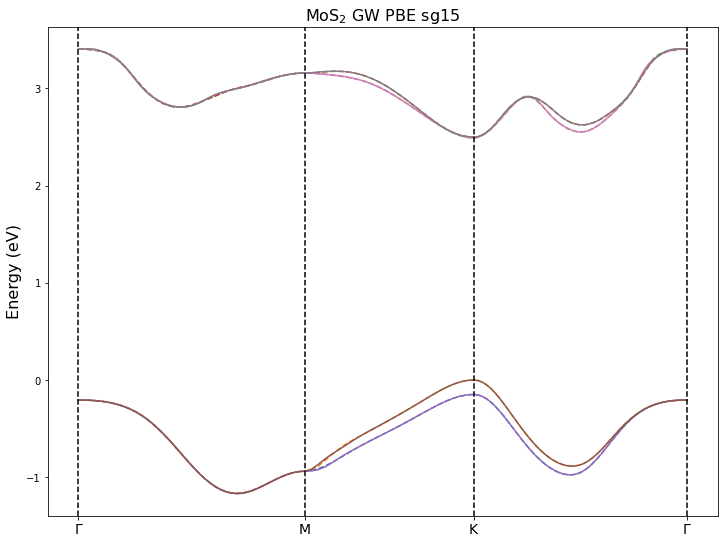

In [16]:
fig, ax = plt.subplots(figsize=(12, 9))
bands_gw.plot(plt,linestyle='--',label='gw_18')
bands_interp.plot(plt,linestyle='-',label='gw_interp')
ax.set_ylabel('Energy (eV)',size=16)
plt.title('MoS$_2$ GW PBE sg15',size=16)

The two results are one on-top of the other so we can assume the reliability of the interpolated db.

### Analysis of the finite q BSE calculation

In [43]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='fastnodes',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,activate_BeeOND=True)
#code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [44]:
#run_dir = 'GW_analysis/kpoints_30-nbnds_250-sg15/'
run_dir = 'GW_analysis/kpoints_24-nbnds_250-sg15/'

RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 40. # Ha use this value for the BSENGexx variable
BndsRnXs = [1,250] # Polarization function bands
FFTGvecs = 30. # Ha 
elec_field = [1.,0.,0.]
BSEBands = [25,28]
energy_range = [0,4] # eV
energy_step = 1000
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

 
#inp = I.YamboInput('yambo -r -rw -o b -k sex -y s',folder=run_dir)
inp = I.YamboInput('yambo -r -o b -k sex -y s',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
inp.set_array_variables(BLongDir=elec_field)
inp.set_array_variables(BSEBands=BSEBands)
inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
inp.set_array_variables(BEnSteps=energy_step)

#inp.set_array_variables(BSEQptR=[1,91]) # 30
inp.set_array_variables(BSEQptR=[1,61]) # 24

inp.set_scalar_variables(BSEmod='causal',Lkind='full')
inp.set_scalar_variables(KfnQPdb='E < ndbs/ndb.QP-kpoints_18 ubi')
inp.set_array_variables(BSSNEig=10)
inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')     
#idd = 'all_Q-bse-bsebands_%s-%s'%(BSEBands[0],BSEBands[1])
idd = 'all_Q-bse-bsebands_%s-%s-norimw'%(BSEBands[0],BSEBands[1])
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=[idd,',ndbs'],reformat=False)

Initialize a Dataset with 1 parallel tasks


In [45]:
inp

{'args': 'yambo -r -o b -k sex -y s',
 'folder': 'GW_analysis/kpoints_24-nbnds_250-sg15/',
 'filename': 'yambo.in',
 'arguments': ['rim_cut', 'bse', 'optics', 'bss', 'WRbsWF', 'photolum'],
 'variables': {'DIP_Threads': [0.0, ''],
  'X_Threads': [0.0, ''],
  'K_Threads': [0.0, ''],
  'RandQpts': [5000000.0, ''],
  'RandGvec': [100, 'RL'],
  'CUTRadius': [0.0, ''],
  'CUTCylLen': [0.0, ''],
  'CUTwsGvec': [0.7, ''],
  'BSENGexx': [40.0, 'Ha'],
  'BSENGBlk': [3.0, 'Ha'],
  'BEnSteps': [1000, ''],
  'BSSNEig': [10, ''],
  'BSSEnTarget': [0.0, 'eV'],
  'BSSSlepcMaxIt': [0.0, ''],
  'CUTGeo': 'slab z',
  'BSKmod': 'SEX',
  'BSEmod': 'casual',
  'BSSmod': 's',
  'BSEprop': 'abs',
  'BSEdips': 'none',
  'CUTBox': [[0.0, 0.0, 0.0], ''],
  'BSEQptR': [[1, 61], ''],
  'BSEBands': [[25, 28], ''],
  'BEnRange': [[0, 4], 'eV'],
  'BDmRange': [[0.05, 0.05], 'eV'],
  'BLongDir': [[1.0, 0.0, 0.0], ''],
  'RandGvecW': [10, 'RL'],
  'FFTGvecs': [30.0, 'Ha'],
  'Lkind': 'full',
  'KfnQPdb': 'E < ndbs/ndb.

In [ ]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo -F all_Q-bse-bsebands_25-28-norimw.in -J "all_Q-bse-bsebands_25-28-norimw,,ndbs" -C all_Q-bse-bsebands_25-28-norimw
slurm submit:  cd GW_analysis/kpoints_24-nbnds_250-sg15/ ; sbatch job_all_Q-bse-bsebands_25-28-norimw.sh
computation all_Q-bse-bsebands_25-28-norimw is running...


### Analysis of the ypp excitonic bands

In [61]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #fastnodes
                memory='124000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
ypp_code = C.YamboCalculator(rr,executable='ypp',activate_BeeOND=True) 
#ypp_code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [62]:
#bands_range = [25,28]
bands_step = 50

# in crystal coordinates
G = [0.,0.,0.]
Kp = [1./3.,1./3.,0.]
Mp = [0.,0.5,0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path
path = [G,Mp,Kp,G]

study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True)

#inp = I.YamboInput(args='mpirun -np 1 ypp -e i -J all_Q-bse-bsebands_25-28',folder=run_dir,filename='ypp.in')
inp = I.YamboInput(args='mpirun -np 1 ypp -e i -J all_Q-bse-bsebands_25-28-norimw',folder=run_dir,filename='ypp.in')
inp.set_array_variables(BANDS_steps=bands_step,BANDS_kpts=path) #BANDS_bands=band_range,
inp.set_scalar_variables(cooIn='rlu',cooOut='rlu')

#idd = 'ypp_excitons'
idd = 'ypp_excitons-norimw'
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [10,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [10,'']
inp.set_scalar_variables(States='1 - 10')
#study.append_run(id=idd,input=inp,runner=ypp_code,jobname=[idd,'all_Q-bse-bsebands_25-28'],skip=False)
study.append_run(id=idd,input=inp,runner=ypp_code,jobname=[idd,'all_Q-bse-bsebands_25-28-norimw'],skip=False)

Initialize a Dataset with 2 parallel tasks


In [63]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'GW_analysis/kpoints_24-nbnds_250-sg15/',
 'num_tasks': 2,
 'verbose': True,
 'input': {'args': 'mpirun -np 1 ypp -e i -J all_Q-bse-bsebands_25-28-norimw',
  'folder': 'GW_analysis/kpoints_24-nbnds_250-sg15/',
  'filename': 'ypp.in',
  'arguments': ['excitons'],
  'variables': {'INTERP_Shell_Fac': [10, ''],
   'INTERP_NofNN': [1.0, ''],
   'BANDS_steps': [50, ''],
   'DOSESteps': [500.0, ''],
   'DOS_broad': [0.1, 'eV'],
   'INTERP_mode': 'BOLTZ',
   'cooIn': 'rlu',
   'cooOut': 'rlu',
   'INTERP_Grid': [['-1', '-1', '-1'], ''],
   'DOSERange': [[1.0, '-1.000000'], 'eV'],
   'BANDS_kpts': [[[0.0, 0.0, 0.0],
     [0.0, 0.5, 0.0],
     [0.3333333333333333, 0.3333333333333333, 0.0],
     [0.0, 0.0, 0.0]],
    ''],
   'GfnQP_DbGd_INTERP_mode': 'BOLTZ',
   'GfnQP_INTERP_shells': [10, ''],
   'States': '1 - 10'}},
 'jobname': ['ypp_excitons-norimw', 'all_Q-bse-bsebands_25-28-norimw'],
 'skip': False,
 'name': 'ypp_excitons-norimw'}

In [64]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete job_out script: GW_analysis/kpoints_24-nbnds_250-sg15/job_ypp_excitons-norimw.out
delete folder: GW_analysis/kpoints_24-nbnds_250-sg15/ypp_excitons-norimw
run command: mpirun -np 16 ypp -F ypp_excitons-norimw.in -J "ypp_excitons-norimw,all_Q-bse-bsebands_25-28-norimw" -C ypp_excitons-norimw
slurm submit:  cd GW_analysis/kpoints_24-nbnds_250-sg15/ ; sbatch job_ypp_excitons-norimw.sh
computation ypp_excitons-norimw is running...
computation ypp_excitons-norimw ended
Run performed in 02s
Task [0] ended 
 


In [51]:
bands_interp = U.BandStructure.from_Ypp(results[0],high_sym,suffix='excitons_interpolated')

We show the GW correction for the valence and conduction bands

Text(0.5, 1.0, 'MoS$_2$ excitonic dispersion')

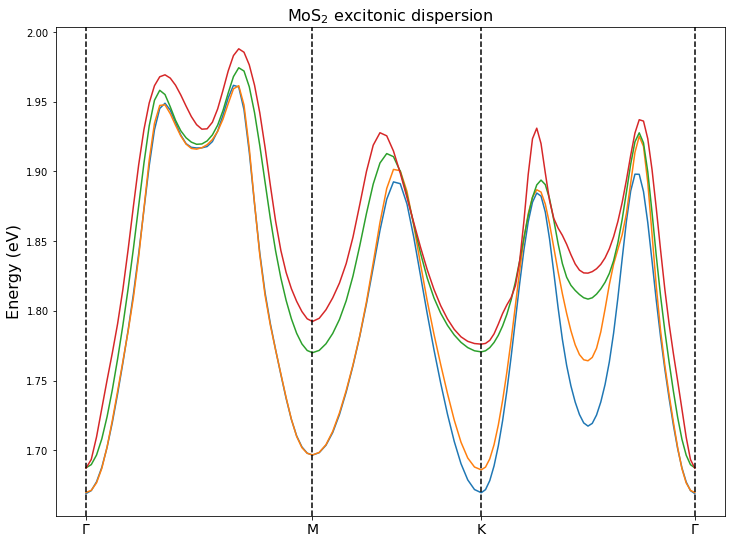

In [52]:
fig, ax = plt.subplots(figsize=(12, 9))
#bands_gw.plot(plt,linestyle='--',label='gw_18')
bands_interp.plot(plt,linestyle='-')
ax.set_ylabel('Energy (eV)',size=16)
plt.title('MoS$_2$ excitonic dispersion',size=16)

Comparison between the 24 and 30 grids

In [65]:
bands_24 = U.BandStructure.from_Ypp_file('GW_analysis/kpoints_24-nbnds_250-sg15/ypp_excitons/o-ypp_excitons.excitons_interpolated',high_sym_points=high_sym)
bands_24_norimw = U.BandStructure.from_Ypp_file('GW_analysis/kpoints_24-nbnds_250-sg15/ypp_excitons-norimw/o-ypp_excitons-norimw.excitons_interpolated',high_sym_points=high_sym)
bands_30 = U.BandStructure.from_Ypp_file('GW_analysis/kpoints_30-nbnds_250-sg15/ypp_excitons/o-ypp_excitons.excitons_interpolated',high_sym_points=high_sym)

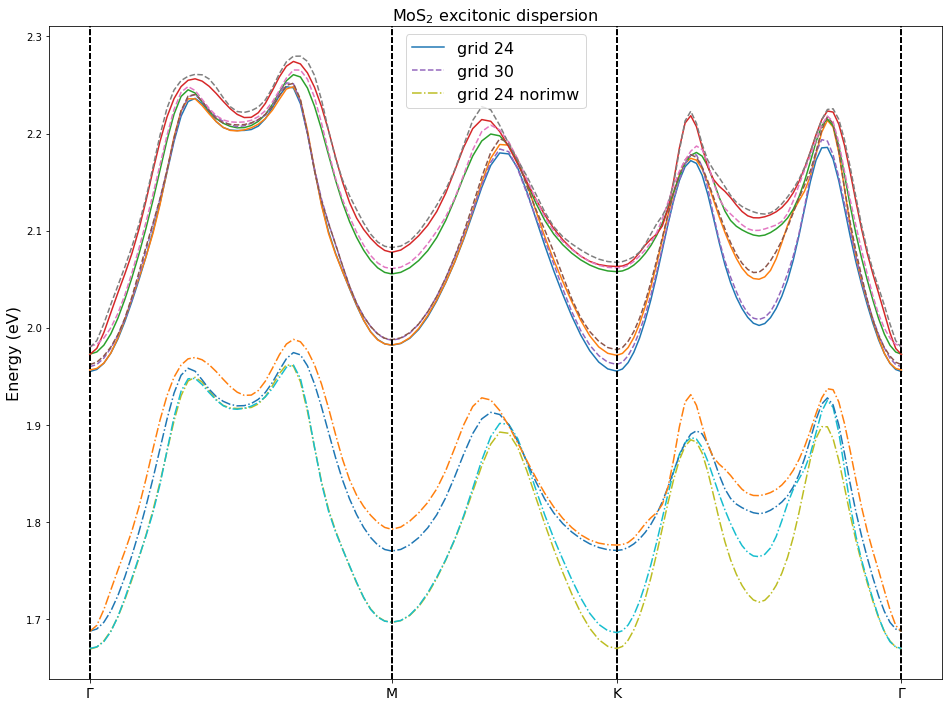

In [56]:
fig, ax = plt.subplots(figsize=(16, 12))
bands_24.plot(plt,linestyle='-',selection=[0],label='grid 24')
bands_24.plot(plt,linestyle='-',selection=[1,2,3])
bands_30.plot(plt,linestyle='--',selection=[0],label='grid 30')
bands_30.plot(plt,linestyle='--',selection=[1,2,3])
bands_24_norimw.plot(plt,linestyle='-.',selection=[0],label='grid 24 norimw')
bands_24_norimw.plot(plt,linestyle='-.',selection=[1,2,3])
ax.set_ylabel('Energy (eV)',size=16)
plt.title('MoS$_2$ excitonic dispersion',size=16)
plt.legend(fontsize=16)

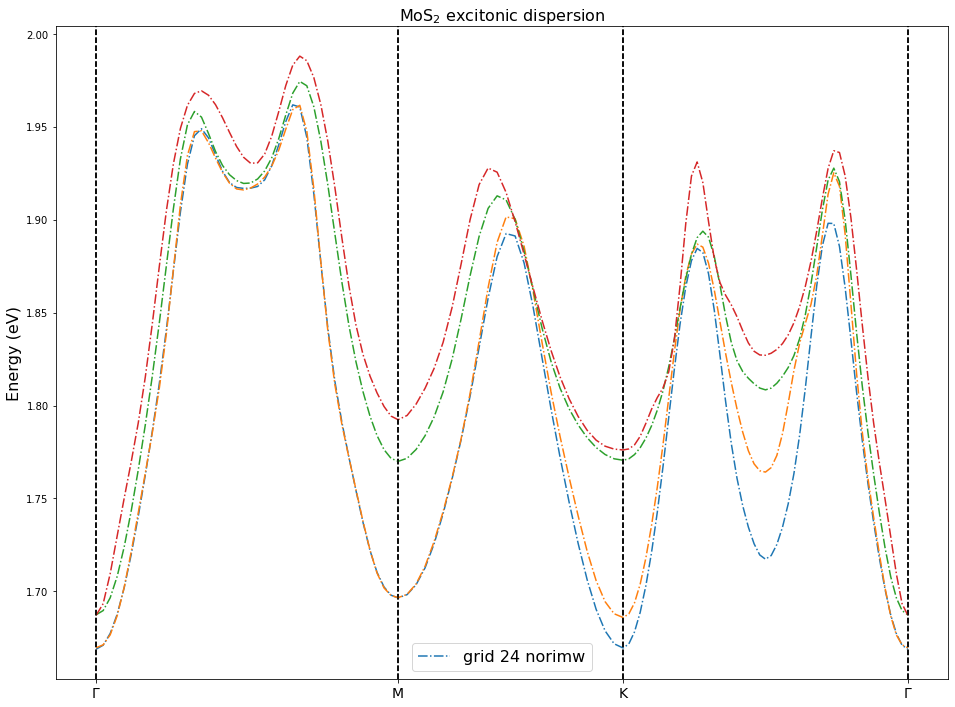

In [69]:
fig, ax = plt.subplots(figsize=(16, 12))
bands_24_norimw.plot(plt,linestyle='-.',selection=[0],label='grid 24 norimw')
bands_24_norimw.plot(plt,linestyle='-.',selection=[1,2,3])
ax.set_ylabel('Energy (eV)',size=16)
#plt.ylim(1.68,1.72)
plt.title('MoS$_2$ excitonic dispersion',size=16)
plt.legend(fontsize=16)

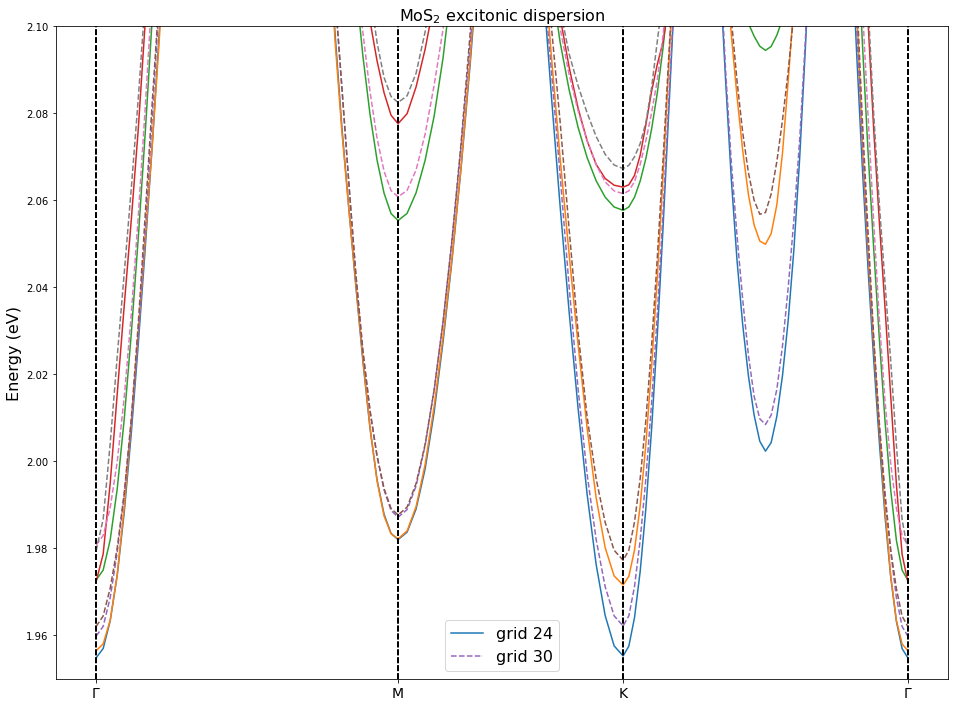

In [14]:
fig, ax = plt.subplots(figsize=(16, 12))
bands_24.plot(plt,linestyle='-',selection=[0],label='grid 24')
bands_24.plot(plt,linestyle='-',selection=[1,2,3])
bands_30.plot(plt,linestyle='--',selection=[0],label='grid 30')
bands_30.plot(plt,linestyle='--',selection=[1,2,3])
ax.set_ylabel('Energy (eV)',size=16)
plt.ylim(1.95,2.1)
plt.title('MoS$_2$ excitonic dispersion',size=16)
plt.legend(fontsize=16)

In [30]:
from scipy.signal import argrelmin

In [31]:
kpath_24 = bands_24.kpath
cond_24 = bands_24.bands[0]
ind_min_24 = argrelmin(cond_24,order=2)[0]

kpath_30 = bands_30.kpath
cond_30 = bands_30.bands[0]
ind_min_30 = argrelmin(cond_30,order=2)[0]

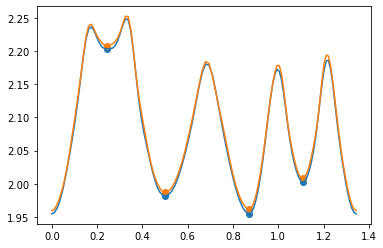

In [34]:
plt.plot(kpath_24,cond_24)
plt.plot(kpath_30,cond_30)
plt.scatter(kpath_24[ind_min_24],cond_24[ind_min_24])
plt.scatter(kpath_30[ind_min_30],cond_30[ind_min_30])

In [37]:
diffe_K = cond_30[ind_min_30[2]]-cond_24[ind_min_24[2]]
diffe_K*1e3

6.895659999999859

In [40]:
diffe_M = cond_30[ind_min_30[1]]-cond_24[ind_min_24[1]]
diffe_M*1e3

5.165220000000081

In [41]:
diffe_G = cond_30[0]-cond_24[0]
diffe_G*1e3

4.998800000000081

In [42]:
diffe_KM_24 = cond_24[ind_min_30[2]]-cond_24[ind_min_30[1]]
diffe_KM_30 = cond_30[ind_min_30[2]]-cond_30[ind_min_30[1]]
diffe_KM_24*1e3,diffe_KM_30*1e3

(-26.73565999999994, -25.00522000000016)

## Analysis of the excitonic dispersion with the experimental lattice constant

We compute the excitonic dispersion on top of the GW quasi particles using the experimental lattice constant

We work on the 24x24x1 using the QP built the same grid

### Analysis of the finite q BSE calculation

In [18]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,activate_BeeOND=True)
#code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [19]:
run_dir = 'GW_analysis/kpoints_24-nbnds_250-sg15-alat_exp/'

RandGvec = 100
Randqpts = 5e6
RandGvecW = 10
BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 20. #40. # Ha use this value for the BSENGexx variable
BndsRnXs = [1,250] # Polarization function bands
FFTGvecs = 30. # Ha 
elec_field = [1.,0.,0.]
BSEBands = [25,28]
energy_range = [0,4] # eV
energy_step = 1000
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

 
inp = I.YamboInput('yambo -r -rw -o b -k sex -y s',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
inp.set_array_variables(BLongDir=elec_field)
inp.set_array_variables(BSEBands=BSEBands)
inp.set_array_variables(units='eV',BEnRange=energy_range,BDmRange=damping)
inp.set_array_variables(BEnSteps=energy_step)

#inp.set_array_variables(BSEQptR=[1,91]) # 30
inp.set_array_variables(BSEQptR=[1,61]) # 24

inp.set_scalar_variables(BSEmod='causal',Lkind='full')
#inp.set_scalar_variables(KfnQPdb='E < ndbs/ndb.QP')
inp.set_array_variables(BSSNEig=10)
inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')     
idd = 'all_Q-bse-bsebands_%s-%s-BSENGexx_%s-nogwqp'%(BSEBands[0],BSEBands[1],EXXRLvcs)
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=[idd,',ndbs'],reformat=False)

Initialize a Dataset with 1 parallel tasks


In [20]:
inp

{'args': 'yambo -r -rw -o b -k sex -y s',
 'folder': 'GW_analysis/kpoints_24-nbnds_250-sg15-alat_exp/',
 'filename': 'yambo.in',
 'arguments': ['rim_cut',
  'rim_w',
  'bse',
  'optics',
  'bss',
  'WRbsWF',
  'photolum'],
 'variables': {'DIP_Threads': [0.0, ''],
  'X_Threads': [0.0, ''],
  'K_Threads': [0.0, ''],
  'RandQpts': [5000000.0, ''],
  'RandGvec': [100, 'RL'],
  'RandGvecW': [10, 'RL'],
  'CUTRadius': [0.0, ''],
  'CUTCylLen': [0.0, ''],
  'CUTwsGvec': [0.7, ''],
  'BSENGexx': [20.0, 'Ha'],
  'BSENGBlk': [3.0, 'Ha'],
  'BEnSteps': [1000, ''],
  'BSSNEig': [10, ''],
  'BSSEnTarget': [0.0, 'eV'],
  'BSSSlepcMaxIt': [0.0, ''],
  'rimw_type': 'default',
  'CUTGeo': 'slab z',
  'BSKmod': 'SEX',
  'BSEmod': 'causal',
  'BSSmod': 's',
  'BSEprop': 'abs',
  'BSEdips': 'none',
  'CUTBox': [[0.0, 0.0, 0.0], ''],
  'BSEQptR': [[1, 61], ''],
  'BSEBands': [[25, 28], ''],
  'BEnRange': [[0, 4], 'eV'],
  'BDmRange': [[0.05, 0.05], 'eV'],
  'BLongDir': [[1.0, 0.0, 0.0], ''],
  'FFTGvecs': 

In [21]:
study.ids

['all_Q-bse-bsebands_25-28-BSENGexx_20.0-nogwqp']

In [ ]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo -F all_Q-bse-bsebands_25-28-BSENGexx_20.0-nogwqp.in -J "all_Q-bse-bsebands_25-28-BSENGexx_20.0-nogwqp,,ndbs" -C all_Q-bse-bsebands_25-28-BSENGexx_20.0-nogwqp
slurm submit:  cd GW_analysis/kpoints_24-nbnds_250-sg15-alat_exp/ ; sbatch job_all_Q-bse-bsebands_25-28-BSENGexx_20.0-nogwqp.sh
computation all_Q-bse-bsebands_25-28-BSENGexx_20.0-nogwqp is running...


### Analysis of the ypp excitonic bands

In [23]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='124000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
ypp_code = C.YamboCalculator(rr,executable='ypp',activate_BeeOND=True) 
#ypp_code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [31]:
#bands_range = [25,28]
bands_step = 50

# in crystal coordinates
G = [0.,0.,0.]
Kp = [1./3.,1./3.,0.]
Mp = [0.,0.5,0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path
path = [G,Mp,Kp,G]

study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True)

#inp = I.YamboInput(args='mpirun -np 1 ypp -e i -J all_Q-bse-bsebands_25-28',folder=run_dir,filename='ypp.in')
inp = I.YamboInput(args='mpirun -np 1 ypp -e i -J all_Q-bse-bsebands_25-28-BSENGexx_20.0-nogwqp',folder=run_dir,filename='ypp.in')
inp.set_array_variables(BANDS_steps=bands_step,BANDS_kpts=path) #BANDS_bands=band_range,
inp.set_scalar_variables(cooIn='rlu',cooOut='rlu')
inp['arguments'].append('BANDS_built_in')

#idd = 'ypp_excitons'
idd = 'ypp_excitons-BSENGexx_20.0-npgwqp'
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [10,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [10,'']
inp.set_scalar_variables(States='1 - 4')
study.append_run(id=idd,input=inp,runner=ypp_code,jobname=[idd,'all_Q-bse-bsebands_25-28-BSENGexx_20.0-nogwqp'],skip=False)

Initialize a Dataset with 2 parallel tasks


In [32]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'GW_analysis/kpoints_24-nbnds_250-sg15-alat_exp/',
 'num_tasks': 2,
 'verbose': True,
 'input': {'args': 'mpirun -np 1 ypp -e i -J all_Q-bse-bsebands_25-28-BSENGexx_20.0-nogwqp',
  'folder': 'GW_analysis/kpoints_24-nbnds_250-sg15-alat_exp/',
  'filename': 'ypp.in',
  'arguments': ['excitons', 'BANDS_built_in'],
  'variables': {'INTERP_Shell_Fac': [10, ''],
   'INTERP_NofNN': [1.0, ''],
   'BANDS_steps': [50, ''],
   'DOSESteps': [500.0, ''],
   'DOS_broad': [0.1, 'eV'],
   'INTERP_mode': 'BOLTZ',
   'cooIn': 'rlu',
   'cooOut': 'rlu',
   'INTERP_Grid': [['-1', '-1', '-1'], ''],
   'DOSERange': [[1.0, '-1.000000'], 'eV'],
   'BANDS_kpts': [[[0.0, 0.0, 0.0],
     [0.0, 0.5, 0.0],
     [0.3333333333333333, 0.3333333333333333, 0.0],
     [0.0, 0.0, 0.0]],
    ''],
   'GfnQP_DbGd_INTERP_mode': 'BOLTZ',
   'GfnQP_INTERP_shells': [10, ''],
   'States': '1 - 4'}},
 'jobname': ['ypp_excitons-BSENGexx_20.0-npgwqp',
  'all_Q-bse-bsebands_25-28-BSENGexx_20.0-nogwqp

In [33]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete job_out script: GW_analysis/kpoints_24-nbnds_250-sg15-alat_exp/job_ypp_excitons-BSENGexx_20.0-npgwqp.out
delete folder: GW_analysis/kpoints_24-nbnds_250-sg15-alat_exp/ypp_excitons-BSENGexx_20.0-npgwqp
run command: mpirun -np 16 ypp -F ypp_excitons-BSENGexx_20.0-npgwqp.in -J "ypp_excitons-BSENGexx_20.0-npgwqp,all_Q-bse-bsebands_25-28-BSENGexx_20.0-nogwqp" -C ypp_excitons-BSENGexx_20.0-npgwqp
slurm submit:  cd GW_analysis/kpoints_24-nbnds_250-sg15-alat_exp/ ; sbatch job_ypp_excitons-BSENGexx_20.0-npgwqp.sh
computation ypp_excitons-BSENGexx_20.0-npgwqp is running...
computation ypp_excitons-BSENGexx_20.0-npgwqp ended
Run performed in 02s
Task [0] ended 
 


In [34]:
bands_interp = U.BandStructure.from_Ypp(results[0],high_sym,suffix='excitons_interpolated')

We show the GW correction for the valence and conduction bands

Text(0.5, 1.0, 'MoS$_2$ excitonic dispersion')

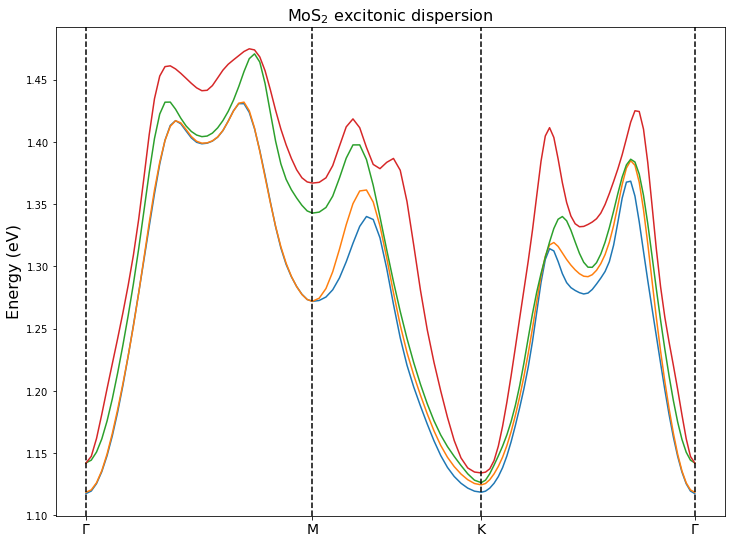

In [35]:
fig, ax = plt.subplots(figsize=(12, 9))
bands_interp.plot(plt,linestyle='-')
ax.set_ylabel('Energy (eV)',size=16)
plt.title('MoS$_2$ excitonic dispersion',size=16)

Text(0.5, 1.0, 'MoS$_2$ excitonic dispersion')

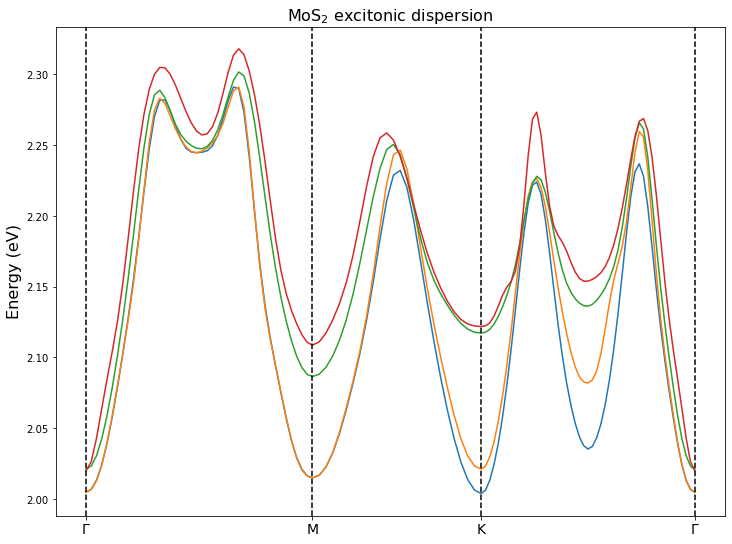

In [17]:
fig, ax = plt.subplots(figsize=(12, 9))
bands_interp.plot(plt,linestyle='-')
ax.set_ylabel('Energy (eV)',size=16)
plt.title('MoS$_2$ excitonic dispersion',size=16)

We compare with the results obtained with the equilibrium lattice parameter 

In [18]:
bands_eq = U.BandStructure.from_Ypp_file('GW_analysis/kpoints_24-nbnds_250-sg15/ypp_excitons/o-ypp_excitons.excitons_interpolated',high_sym_points=high_sym)

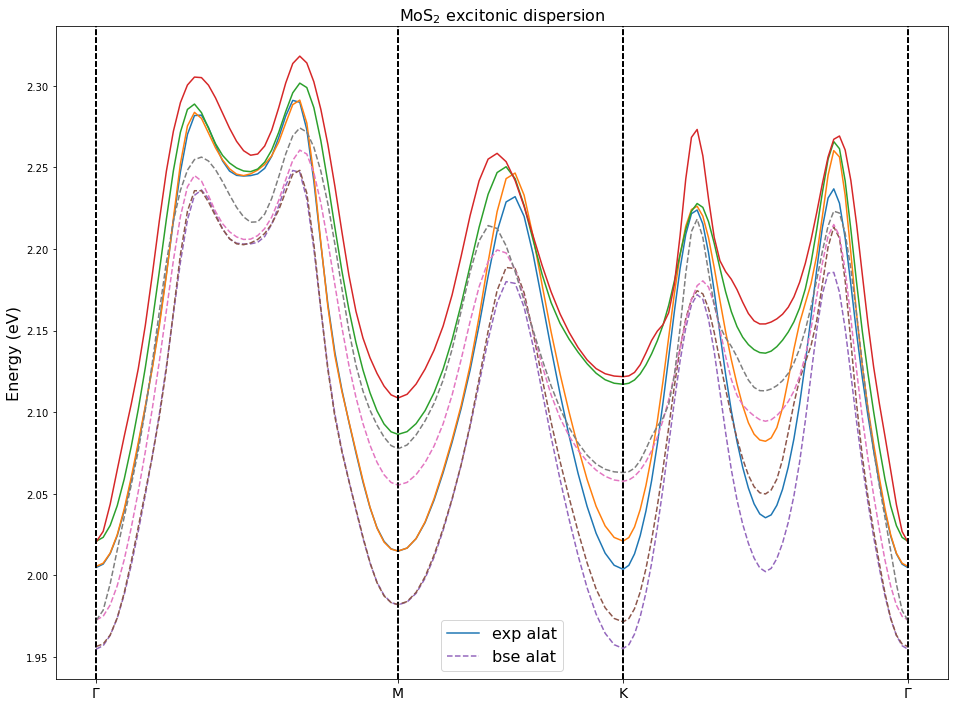

In [19]:
fig, ax = plt.subplots(figsize=(16, 12))
bands_interp.plot(plt,linestyle='-',selection=[0],label='exp alat')
bands_interp.plot(plt,linestyle='-',selection=[1,2,3])
bands_eq.plot(plt,linestyle='--',selection=[0],label='bse alat')
bands_eq.plot(plt,linestyle='--',selection=[1,2,3])
ax.set_ylabel('Energy (eV)',size=16)
plt.title('MoS$_2$ excitonic dispersion',size=16)
plt.legend(fontsize=16)

## Analysis of the XUV absorption with the o -c option

In [123]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2
module = '/home/dalessandro/module_script/yambo_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.YamboCalculator(rr,activate_BeeOND=True)
#code.global_options()

Initialize a Yambo calculator with scheduler slurm


In [124]:
input_dir = 'DFT_analysis/kpoints_18-nbnds_250.save'
run_dir = 'MB_analysis/kpoints_18-nbnds_250'
Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)    

SAVE folder MB_analysis/kpoints_18-nbnds_250/SAVE already present. No operations performed.


We want to identify the set of bands that include the semi-core -> conduction transitions that are resonant with the valence -> continuum ones

In [125]:
dft_gap = 1.78
exp_gap = 2.4 # value to be checked
scissor = exp_gap-dft_gap # eV
print('scissor',scissor)

scissor 0.6199999999999999


In [126]:
pw_data = P.PwParser('DFT_analysis/kpoints_18-nbnds_250.save/data-file-schema.xml')

Parse file : DFT_analysis/kpoints_18-nbnds_250.save/data-file-schema.xml


We seek for the energies differences at the K point which is tha last in the energies array

In [112]:
energies = pw_data.get_evals(set_scissor=scissor)[-1]

Apply a scissor of 0.6199999999999999 eV


Semicore states go from 3 to 8 and the conduction level is the 26-th state so the energy range of this transitions is

In [58]:
energies[26]-energies[8],energies[26]-energies[3]

(14.372336975632559, 39.014727785855726)

Transitions from valence to continuum in this range are 

In [59]:
for ind in range(84,240):
    print(ind,energies[ind]-energies[26])

84 14.456437289704901
85 14.457473060319053
86 14.805590440442828
87 14.833439304815293
88 15.112059564541255
89 15.120527393200046
90 15.387642074423816
91 15.39051972745417
92 15.400705252884809
93 15.401481712235064
94 15.885766815243077
95 15.885947928415334
96 17.12604487843768
97 17.31378810384312
98 17.40455345987684
99 17.405460248287497
100 17.69583199577752
101 17.69690647213301
102 18.039453149741462
103 18.042988916473906
104 18.376549307371096
105 18.38504242520832
106 18.547761841299828
107 18.55638560827516
108 19.7579566818636
109 19.768353556584998
110 20.30660355716222
111 20.31919946917999
112 21.544303070184853
113 21.54931629408965
114 21.639173541310058
115 21.643851076328573
116 21.71678483232887
117 21.727655693602586
118 22.145045952104432
119 22.147336585949468
120 23.182276642303954
121 23.185221922279574
122 23.622172125540942
123 23.625416951045118
124 23.812613760184917
125 23.830235292529416
126 24.04744312384686
127 24.06398139058119
128 24.1004663471842

So we perform a BSE computation including bands up to the 240-th

In [129]:
RandGvec = 100
Randqpts = 5e6
NGsBlkXd = [5.] #[5.,10.]  # Ha  values of the BSENGBlk variable
EXXRLvcs = 30. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha 
elec_field = [1.,0.,0.]
EnRngeXd = [30,50] # eV
BEnSteps = 1000
BndsRnXd = [1,240]
#BSEHoleBands = [3,8] #[3,12] 
#BSEElecBands = [27,44] #[27,38] #[27,34] #[27,30] #[27,28]
damping = [0.05,0.05] # eV

study = D.Dataset(num_tasks=2,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -r -o c -k hartree ',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='eV',EnRngeXd=EnRngeXd,BDmRange=damping)
inp.set_array_variables(BEnSteps=BEnSteps,QpntsRXd=[1,1])
inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t') #  1 node with 32 mpi and 1 omp  
#inp.set_scalar_variables(BS_CPU='32.2.1',BS_ROLEs= 'k.eh.t') #  2 nodes with 32 mpi and 1 omp      
#inp.set_array_variables(BSEBands=BSEBands) #,BSEHoleBands=BSEHoleBands,BSEElecBands=elecbands

for ngsblkxd in NGsBlkXd:
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,NGsBlkXd=ngsblkxd,FFTGvecs=FFTGvecs)
    idd = 'bse-xuv-gspace-bsengblk_%s-fine_sampling'%ngsblkxd    
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=[idd,'ndbs'],reformat=False)

Initialize a Dataset with 2 parallel tasks


In [130]:
study.ids

['bse-xuv-gspace-bsengblk_5.0-fine_sampling']

In [131]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'MB_analysis/kpoints_18-nbnds_250',
 'num_tasks': 2,
 'verbose': True,
 'skip': True,
 'input': {'args': 'yambo -r -o c -k hartree ',
  'folder': 'MB_analysis/kpoints_18-nbnds_250',
  'filename': 'yambo.in',
  'arguments': ['rim_cut', 'chi', 'optics', 'kernel'],
  'variables': {'DIP_Threads': [0.0, ''],
   'X_Threads': [0.0, ''],
   'RandQpts': [5000000.0, ''],
   'RandGvec': [100, 'RL'],
   'CUTRadius': [0.0, ''],
   'CUTCylLen': [0.0, ''],
   'CUTwsGvec': [0.7, ''],
   'NGsBlkXd': [5.0, 'Ha'],
   'ETStpsXd': [100.0, ''],
   'CUTGeo': 'slab z',
   'Chimod': 'HARTREE',
   'CUTBox': [[0.0, 0.0, 0.0], ''],
   'QpntsRXd': [[1, 1], ''],
   'BndsRnXd': [[1, 250], ''],
   'EnRngeXd': [[30, 50], 'eV'],
   'DmRngeXd': [[0.1, 0.1], 'eV'],
   'LongDrXd': [[1.0, 0.0, 0.0], ''],
   'BLongDir': [[1.0, 0.0, 0.0], ''],
   'KfnQP_E': [[0.6199999999999999, 1.0, 1.0], ''],
   'BDmRange': [[0.05, 0.05], 'eV'],
   'BEnSteps': [1000, ''],
   'BS_CPU': '32.1.1',
   'BS_ROLEs

In [132]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo -F bse-xuv-gspace-bsengblk_5.0-fine_sampling.in -J "bse-xuv-gspace-bsengblk_5.0-fine_sampling,ndbs" -C bse-xuv-gspace-bsengblk_5.0-fine_sampling
slurm submit:  cd MB_analysis/kpoints_18-nbnds_250 ; sbatch job_bse-xuv-gspace-bsengblk_5.0-fine_sampling.sh
computation bse-xuv-gspace-bsengblk_5.0-fine_sampling is running...
computation bse-xuv-gspace-bsengblk_5.0-fine_sampling ended
Run performed in 21m-49s
Task [0] ended 
 


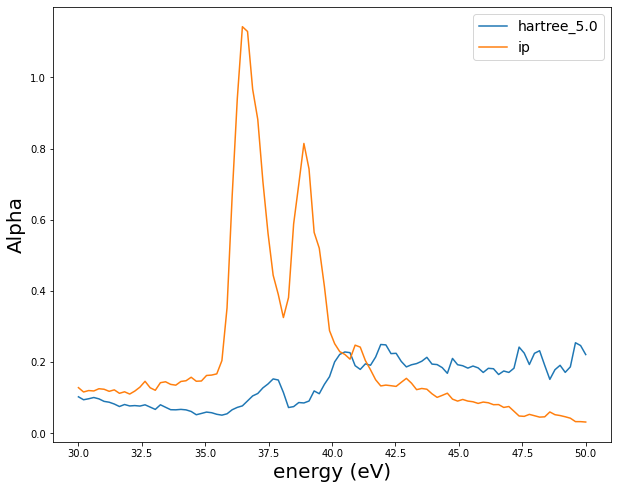

In [133]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind in range(len(NGsBlkXd)):
    data = results[ind].data['alpha_q1_inv_rpa_dyson']
    energy = data['col1']
    alpha_im = data['col2']
    ax.plot(energy,alpha_im,label='hartree_%s'%NGsBlkXd[ind])
data = results[0].data['alpha_q1_inv_rpa_dyson']
energy = data['col1']
alpha_o_im = data['col4']
ax.plot(energy,alpha_o_im,label='ip')
ax.legend()
ax.set_ylabel('Alpha',size=20)
ax.set_xlabel('energy (eV)',size=20)
#ax.set_xlim(30,50)
#ax.set_ylim(-0.5,2.5)
ax.legend(fontsize=14)                 

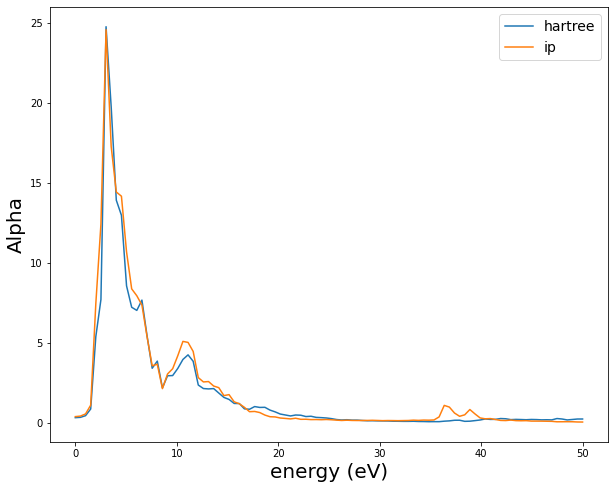

In [95]:
data = results[0].data['alpha_q1_inv_rpa_dyson']
energy = data['col1']
alpha_im = data['col2']
alpha_o_im = data['col4']

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(energy,alpha_im,label='hartree')
ax.plot(energy,alpha_o_im,label='ip')
ax.legend()
ax.set_ylabel('Alpha',size=20)
ax.set_xlabel('energy (eV)',size=20)
#ax.set_xlim(30,50)
#ax.set_ylim(-0.5,2.5)
ax.legend(fontsize=14)

## Plots

In [134]:
full = P.YamboOutputParser.from_file('BSE_analysis/kpoints_18-nbnds_250/bse-xuv-holebands_3-8-elecbands_27-44-bsengblk_3.0/o-bse-xuv-holebands_3-8-elecbands_27-44-bsengblk_3.0.alpha_q1_haydock_bse')
hartree = P.YamboOutputParser.from_file('BSE_analysis/kpoints_18-nbnds_250/bse-xuv-Hartree-holebands_3-8-elecbands_27-44/o-bse-xuv-Hartree-holebands_3-8-elecbands_27-44.alpha_q1_haydock_bse')
gspace = P.YamboOutputParser.from_file('MB_analysis/kpoints_18-nbnds_250/bse-xuv-gspace-bsengblk_5.0-fine_sampling/o-bse-xuv-gspace-bsengblk_5.0-fine_sampling.alpha_q1_inv_rpa_dyson')

Parse file BSE_analysis/kpoints_18-nbnds_250/bse-xuv-holebands_3-8-elecbands_27-44-bsengblk_3.0/o-bse-xuv-holebands_3-8-elecbands_27-44-bsengblk_3.0.alpha_q1_haydock_bse
Parse file BSE_analysis/kpoints_18-nbnds_250/bse-xuv-Hartree-holebands_3-8-elecbands_27-44/o-bse-xuv-Hartree-holebands_3-8-elecbands_27-44.alpha_q1_haydock_bse
Parse file MB_analysis/kpoints_18-nbnds_250/bse-xuv-gspace-bsengblk_5.0-fine_sampling/o-bse-xuv-gspace-bsengblk_5.0-fine_sampling.alpha_q1_inv_rpa_dyson


In [135]:
data_full, data_hartree, data_gspace = full['alpha_q1_haydock_bse'], hartree['alpha_q1_haydock_bse'], gspace['alpha_q1_inv_rpa_dyson']

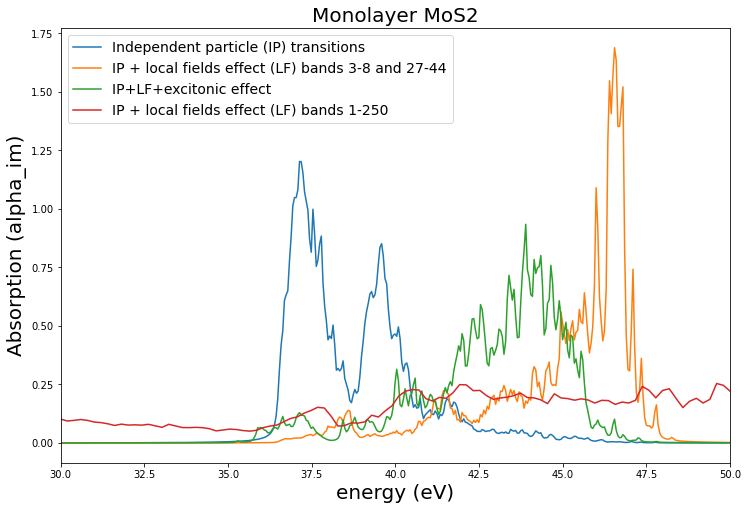

In [145]:
fig, ax = plt.subplots(figsize=(12, 8))
energy_full, energy_hartree, energy_gspace = data_full['energy'], data_hartree['energy'], data_gspace['col1']
alpha_full_im, alpha_hartree_im, alpha_gspace_im = data_full['alpha_imag'], data_hartree['alpha_imag'], data_gspace['col2']
alpha_o_im = data_full['alpha_o_imag']
ax.plot(energy_full,alpha_o_im,label='Independent particle (IP) transitions')
ax.plot(energy_hartree,alpha_hartree_im,label='IP + local fields effect (LF) bands 3-8 and 27-44')
ax.plot(energy_full,alpha_full_im,label='IP+LF+excitonic effect')
ax.plot(energy_gspace,alpha_gspace_im,label='IP + local fields effect (LF) bands 1-250')
ax.set_ylabel('Absorption (alpha_im)',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_xlim(30,50)
#ax.set_ylim(-0.05,1.8)
ax.legend(fontsize=14)
ax.set_title('Monolayer MoS2',size=20)


plt.savefig(fname='Plot/Monolayer_Absorption_xuv.jpg',format='jpg',bbox_inches = "tight")